# Pitch Classification Intro
The purpose of this dataset is to work on a classification pipeline for the pitch type selection.

Importing various packages:

In [1]:
import pickle
from sqlalchemy import create_engine
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [3]:
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

Pickling in the data from data_cleaning.ipynb:

In [4]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [2]:
#Commenting out after initial run:
#with open('../Data/cleaned_pitch_df.pickle','rb') as read_file:
#    pitch_df = pickle.load(read_file)

In [12]:
pitch_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season'],
      dtype='object')

For classification purposes, I'll have the following features for now:
- 'inning', 'top', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed', 'pitcher_run_diff'
- I will be using 'pitch_type' as the label (i.e. will need to code this with numbers)
- Due to the differences in pitcher' styles, my plan will be to train models on individual pitchers, using the same pipeline steps.  
- For now, I'll be using just this data to set up a workflow.  Once other data (namely, pitch arsenal and hitter clustering) are ready, they will be incorporated.

# Dataframe Prep

## Split: Train/Val and Test

For puposes of training/validating and testing my model(s), I'll be splitting as follows: 
- Train/Val: 2015-2018 seasons
- Test: 2019 season

The thought here is to simulate using a few previous seasons' worth of data to predict for an upcoming season.

In [15]:
pitch_df[pitch_df.Season == 2019].shape

(707463, 34)

In [16]:
pitch_df[pitch_df.Season != 2019].shape

(2848371, 34)

Based on the numbers, this is an ~80/20 split in data.

In [17]:
train_df = pitch_df[pitch_df.Season != 2019]

In [18]:
test_df = pitch_df[pitch_df.Season == 2019]

In [12]:
train_df.pitcher_full_name.value_counts()

Max Scherzer        13479
Justin Verlander    12810
Chris Archer        12760
Jose Quintana       12692
Chris Sale          12689
                    ...  
Alexi Amarista          3
Mark Reynolds           3
Phillip Ervin           3
Anthony Rizzo           2
Chris Denorfia          2
Name: pitcher_full_name, Length: 1329, dtype: int64

### First Pitch Types:

Right now, last pitch type, speed, and location is all null for the first pitch of an at-bat, since there aren't any other pitchs in that at bat.  To remove the null information, I will add in the first pitch from the *previous* at bat, since that could inform how a pitcher opens at bats.

### Changing the below to markdown after initial run:

pitchers = train_df.pitcher_full_name.value_counts().index

*NOTE: I'm Commenting out the below after firt run/pickling due to run time:*

Train:

In [13]:
# for pitcher in pitchers:
#     filtered_df = train_df[(train_df.pitcher_full_name == pitcher) & (train_df.pitch_num == 1)].sort_values(by=['ab_id'])
#     first_pitches = filtered_df.index[1:]
#     for i, first_pitch in enumerate(first_pitches, 1):
#         last_first_pitch = train_df.pitch_type.iloc[filtered_df.index[i-1]]
#         last_first_px = train_df.px.iloc[filtered_df.index[i-1]]
#         last_first_pz = train_df.pz.iloc[filtered_df.index[i-1]]
#         last_first_speed = train_df.start_speed.iloc[filtered_df.index[i-1]]
        
#         train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
#         train_df.last_pitch_px.iloc[first_pitch] = last_first_px
#         train_df.last_pitch_pz.iloc[first_pitch] = last_first_pz
#         train_df.last_pitch_speed.iloc[first_pitch] = last_first_speed
    

Pickling this df, just so I don't have to re-run the first pitch assignments:

pwd

with open('../Data/train_df_post_first.pickle', 'wb') as to_write:
    pickle.dump(train_df, to_write)

Pickling it back in:

In [14]:
with open('../Data/train_df_post_first.pickle','rb') as read_file:
    train_df = pickle.load(read_file)

Test: here, I'll be running the same code on the test set:

In [19]:
pitchers_test = test_df.pitcher_full_name.value_counts().index

In [20]:
test_df[test_df.pitch_num == 1]

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,pitch_num,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season
2848371,1.0,594777,571666,1.0,2.019000e+09,0.0,L,R,Flyout,oak,...,1.0,None,NaN,NaN,NaN,Mike Fiers,0.0,Kole Calhoun,2019-03-28,2019
2848372,1.0,545361,571666,1.0,2.019000e+09,0.0,R,R,Flyout,oak,...,1.0,None,NaN,NaN,NaN,Mike Fiers,0.0,Mike Trout,2019-03-28,2019
2848377,1.0,571506,571666,1.0,2.019000e+09,0.0,L,R,Groundout,oak,...,1.0,None,NaN,NaN,NaN,Mike Fiers,0.0,Justin Bour,2019-03-28,2019
2848382,1.0,543257,502239,0.0,2.019000e+09,0.0,L,R,Single,oak,...,1.0,None,NaN,NaN,NaN,Trevor Cahill,0.0,Robbie Grossman,2019-03-28,2019
2848384,1.0,656305,502239,0.0,2.019000e+09,0.0,R,R,Flyout,oak,...,1.0,None,NaN,NaN,NaN,Trevor Cahill,0.0,Matt Chapman,2019-03-28,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572164,8.0,643376,656222,0.0,2.019185e+09,1.0,R,L,Strikeout,tor,...,1.0,None,NaN,NaN,NaN,Jalen Beeks,-3.0,Danny Jansen,2019-09-28,2019
3572168,8.0,620446,656222,0.0,2.019185e+09,1.0,R,L,Forceout,tor,...,1.0,None,NaN,NaN,NaN,Jalen Beeks,-3.0,Richard Urena,2019-09-28,2019
3572173,9.0,663993,571704,1.0,2.019185e+09,4.0,L,R,Groundout,tor,...,1.0,None,NaN,NaN,NaN,Ken Giles,3.0,Nate Lowe,2019-09-28,2019
3572175,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,1.0,None,NaN,NaN,NaN,Ken Giles,3.0,Matt Duffy,2019-09-28,2019


In [3]:
# Commenting out after initial run, due to run time:
# for pitcher in pitchers_test:
#     filtered_df = test_df[(test_df.pitcher_full_name == pitcher) & (test_df.pitch_num == 1)].sort_values(by=['ab_id'])
#     first_pitches = filtered_df.index[1:]
#     for i, first_pitch in enumerate(first_pitches, 1):
#         last_first_pitch = test_df.pitch_type.loc[filtered_df.index[i-1]]
#         last_first_px = test_df.px.loc[filtered_df.index[i-1]]
#         last_first_pz = test_df.pz.loc[filtered_df.index[i-1]]
#         last_first_speed = test_df.start_speed.loc[filtered_df.index[i-1]]
        
#         test_df.last_pitch_type.loc[first_pitch] = last_first_pitch
#         test_df.last_pitch_px.loc[first_pitch] = last_first_px
#         test_df.last_pitch_pz.loc[first_pitch] = last_first_pz
#         test_df.last_pitch_speed.loc[first_pitch] = last_first_speed
    

Testing on Trevor Bauer:

In [30]:
filtered_df = test_df[['ab_id','pitch_type', 'px', 'pz', 'start_speed', 'last_pitch_type', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed']][(test_df.pitcher_full_name =='Trevor Bauer') & (test_df.pitch_num == 1)].sort_values(by='ab_id')

In [31]:
filtered_df.head(20)

,ab_id,pitch_type,px,pz,start_speed,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed
2857130,2.019002e+09,FF,-1.87,3.93,95.2,None,NaN,NaN,NaN
2857133,2.019002e+09,FF,-0.54,2.47,93.7,FF,-1.87,3.93,95.2
2857137,2.019002e+09,FF,0.47,1.74,95.6,FF,-0.54,2.47,93.7
2857164,2.019002e+09,FF,-0.60,2.48,93.3,FF,0.47,1.74,95.6
2857169,2.019002e+09,FF,-0.33,2.01,94.6,FF,-0.60,2.48,93.3
2857175,2.019002e+09,FF,-0.81,3.64,95.3,FF,-0.33,2.01,94.6
2857195,2.019002e+09,FF,0.35,1.31,95.0,FF,-0.81,3.64,95.3
2857199,2.019002e+09,FC,0.72,1.87,83.8,FF,0.35,1.31,95.0
2857205,2.019002e+09,FF,0.30,3.94,95.8,FC,0.72,1.87,83.8
2857227,2.019002e+09,CH,-0.08,2.40,86.5,FF,0.30,3.94,95.8


Perfect, that has worked as intended.

## Feature Prep

Here, I"ll be preparing the dataframe for modeling.  I'll be starting with just a subset of one pitcher's pitches as a proof of concept, using Max Scherzer's pitch totals, since he has the most of any pitcher.

In [15]:
scherzer_df = train_df[train_df.pitcher_full_name == 'Max Scherzer']

In [16]:
scherzer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13479 entries, 2396 to 2824573
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   inning             13479 non-null  float64       
 1   batter_id          13479 non-null  int64         
 2   pitcher_id         13479 non-null  int64         
 3   top                13479 non-null  float64       
 4   ab_id              13479 non-null  float64       
 5   p_score            13479 non-null  float64       
 6   stand              13479 non-null  object        
 7   p_throws           13479 non-null  object        
 8   event              13479 non-null  object        
 9   home_team          13479 non-null  object        
 10  away_team          13479 non-null  object        
 11  b_score            13479 non-null  float64       
 12  on_1b              13479 non-null  float64       
 13  on_2b              13479 non-null  float64       
 14  o

The following columns will need to be one-hot encoded: 
- stand (hitter hand), p_throws (pitcher throwing hand), last_pitch_type

In [17]:
ohe_cols = ['stand', 'p_throws', 'last_pitch_type']

To run one-hot encoding, I'll be utilizing the column_ohe_maker function in pitch_cat_functions.py:

In [18]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [20]:
from pitch_cat_functions import *

In [21]:
new_df = column_ohe_maker(scherzer_df, ohe_cols)

In [22]:
new_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,event,home_team,away_team,b_score,...,Date_Time_Date,Season,stand_R,last_pitch_type_CU,last_pitch_type_FC,last_pitch_type_FF,last_pitch_type_FT,last_pitch_type_SL,last_pitch_type_UN,last_pitch_type_None
2396,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2397,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2398,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2399,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2400,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
new_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None'],
      dtype='object')

Excellent, those are now one-hot encoded.

In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13479 entries, 2396 to 2824573
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   inning                13479 non-null  float64       
 1   batter_id             13479 non-null  int64         
 2   pitcher_id            13479 non-null  int64         
 3   top                   13479 non-null  float64       
 4   ab_id                 13479 non-null  float64       
 5   p_score               13479 non-null  float64       
 6   event                 13479 non-null  object        
 7   home_team             13479 non-null  object        
 8   away_team             13479 non-null  object        
 9   b_score               13479 non-null  float64       
 10  on_1b                 13479 non-null  float64       
 11  on_2b                 13479 non-null  float64       
 12  on_3b                 13479 non-null  float64       
 13  px         

## Numerical Conversion of Target:

In order to represent the pitch_type as multiple classes, I'll need to convert the object values to numerical values.  This will be done via the pitch_type_to_num function in pitch_cat_functions.py.

In [25]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [26]:
output_df.pitch_type.value_counts()

FF    7117
SL    2639
CH    1856
CU    1090
FC     688
FT      89
Name: pitch_type, dtype: int64

In [27]:
output_df.Pitch_Type_Num.value_counts()

0    7117
1    2639
2    1856
3    1090
4     688
5      89
Name: Pitch_Type_Num, dtype: int64

The pitch types and codes match, so the function is behaving as anticipated.

## Random Forest Classification:

Here, I'll run Max Scherzer's pitches through a Random Forest classifier to predict pitch types, using K-Fold cross validation.

In [29]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz']

In [30]:
model_df = output_df[output_df.last_pitch_px.notnull()]

In [31]:
X = model_df[col]

In [32]:
y = model_df['Pitch_Type_Num']

Random Forest Results for Max Scherzer
Confusion Matrix for Fold 1
[[1172  150   49   14    6    0]
 [ 385  162   11    2    1    0]
 [ 281   36   35    9    3    0]
 [ 184    6   15    6    0    0]
 [ 121    7   12    2    3    0]
 [  19    1    0    2    0    0]]


Confusion Matrix for Fold 2
[[1205  170   44   21    3    0]
 [ 318  158    9    0    0    0]
 [ 314   53   28    6    0    0]
 [ 173    7   12    7    4    0]
 [ 121    1    9    5    3    0]
 [  18    4    0    0    0    0]]


Confusion Matrix for Fold 3
[[1220  151   36   17    4    0]
 [ 342  155   10    0    1    2]
 [ 313   33   20    4    4    0]
 [ 202    7    9   10    1    0]
 [ 118    3    7    4    3    0]
 [  15    2    0    0    0    0]]


Confusion Matrix for Fold 4
[[1156  191   48   14    6    0]
 [ 393  156    6    2    0    0]
 [ 293   42   28    5    1    1]
 [ 180    7   11    8    1    0]
 [ 110    4   14    3    0    0]
 [   7    5    1    0    0    0]]


Confusion Matrix for Fold 5
[[1211  150   52 

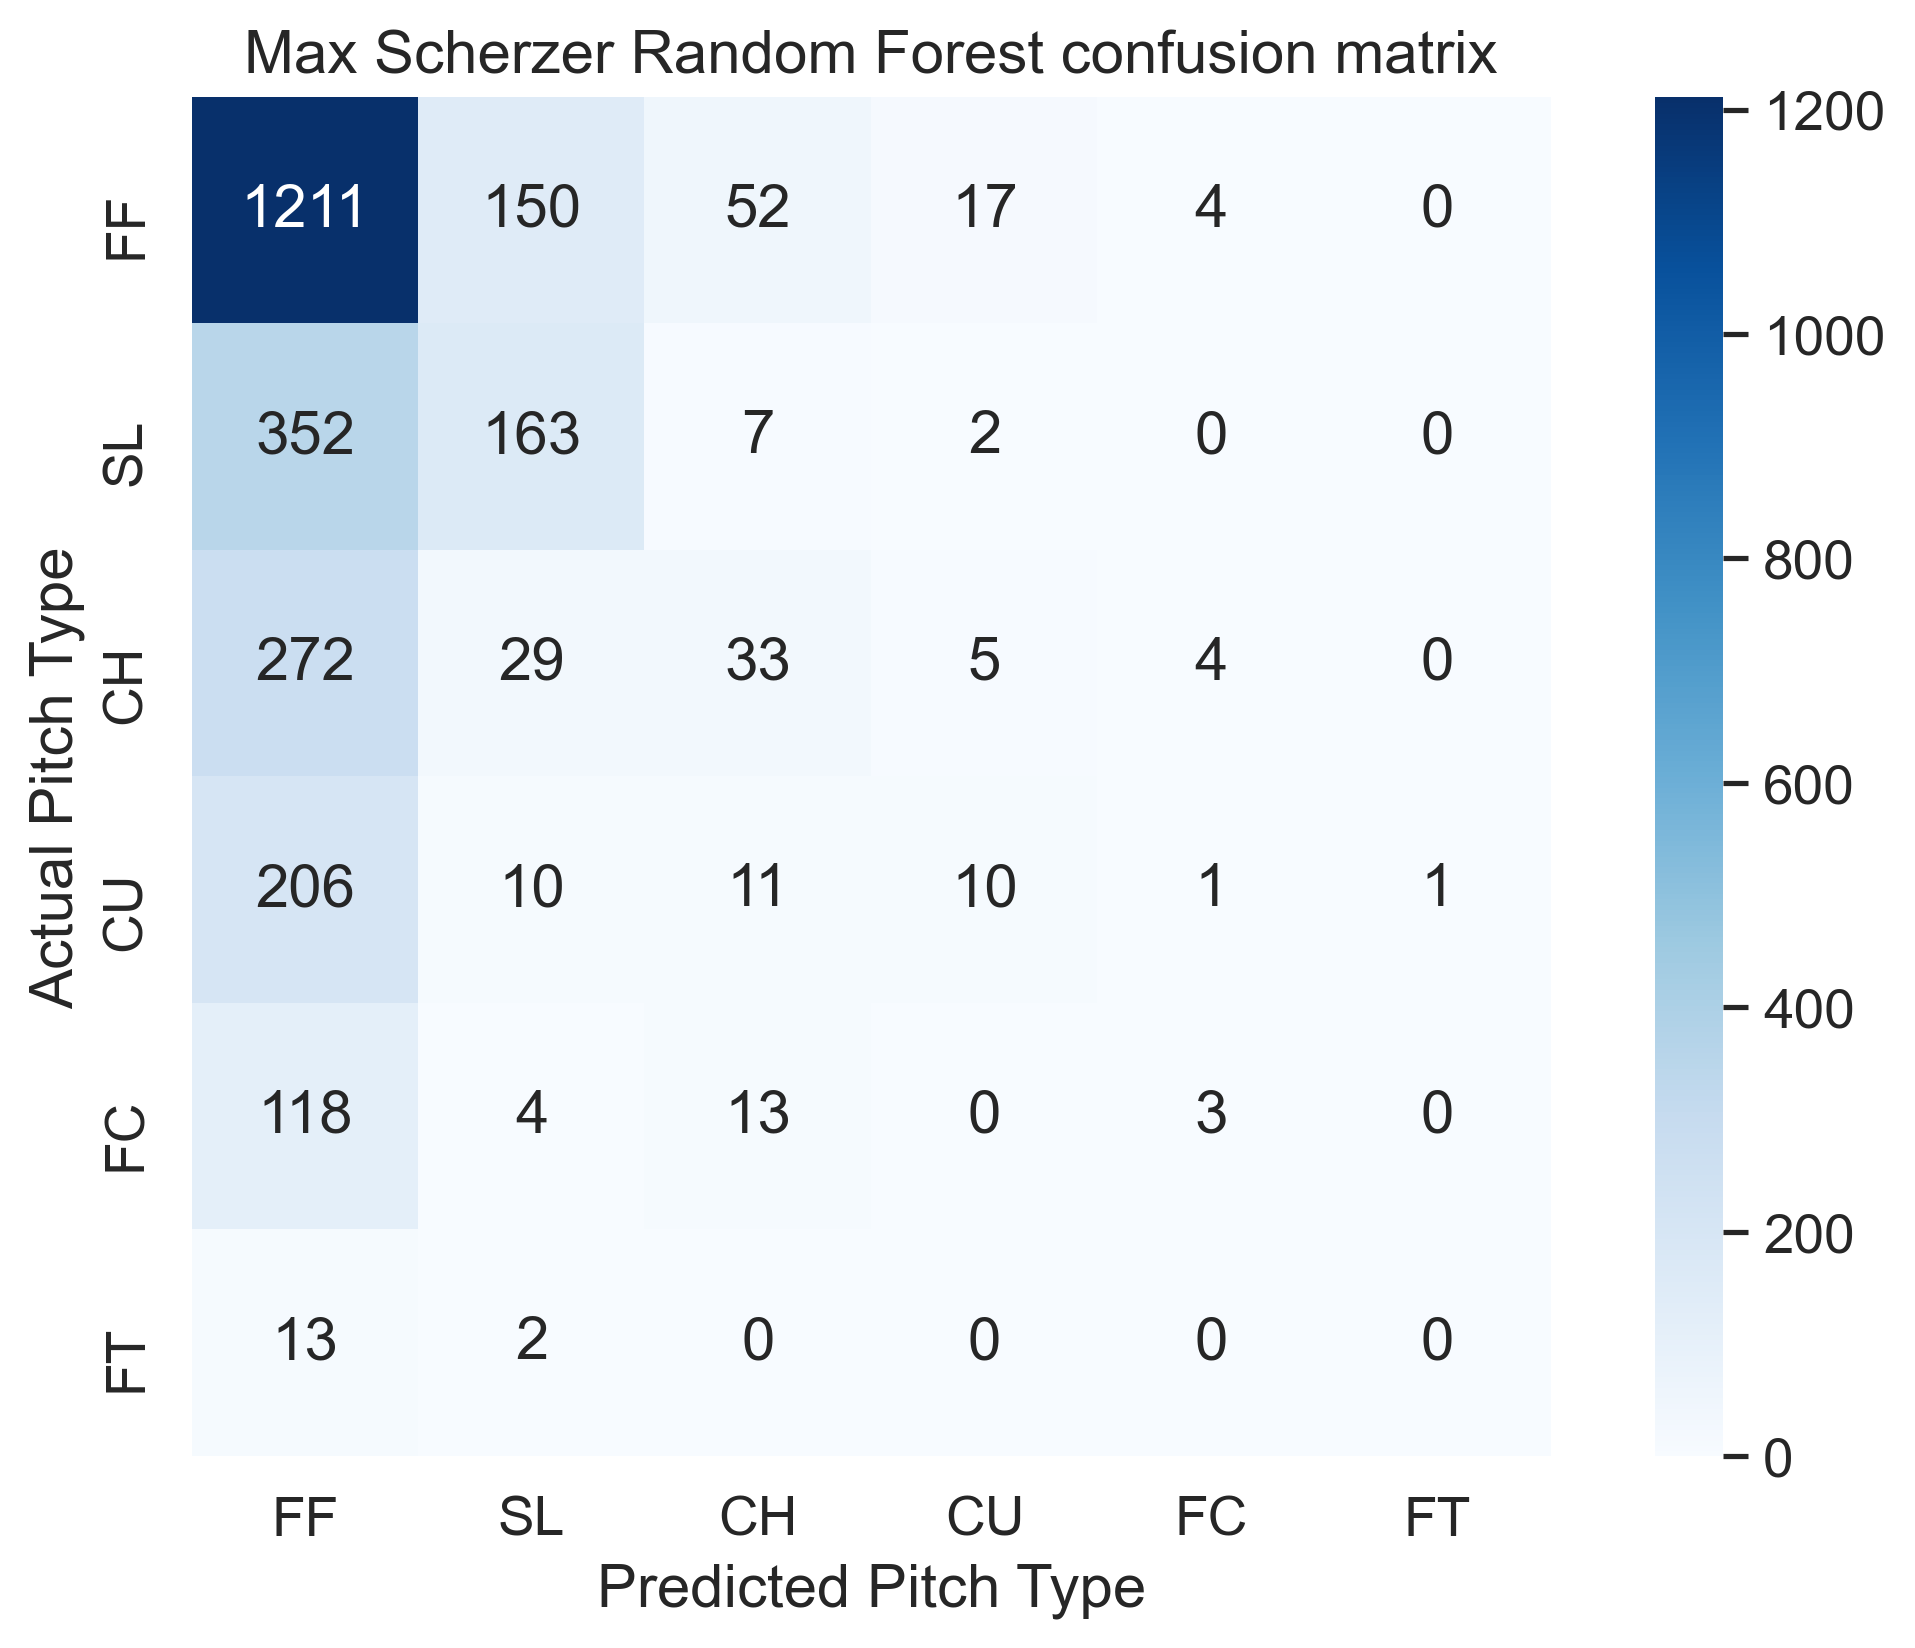

In [33]:
model = random_forest_eval_kfold('Max Scherzer',X,y, model_df,k=5)

The model is doing it's best with four seam fastballs, which is good since that is the most commonly thrown pitch as shown in my EDA.  It is struggling (on the surface) with other pitch types, though.  I am hopeful that adding in the running rates of these pitchers that each pitcher throws will help with that.

In the meantime, I'll test out the pipeline I've developed with some of the other pitchers in the dataset.

### RA Dickey

RA Dickey was a very heavy knuckleball pitcher.  I am curious to see how it works with him.

In [34]:
dickey_df = train_df[train_df.pitcher_full_name == 'R.A. Dickey']

In [35]:
new_df = column_ohe_maker(dickey_df, ohe_cols)

In [36]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'KN': 0, 'FF': 1, 'EP': 2}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [37]:
output_df.pitch_type.value_counts()

KN    7461
FF    1194
EP     203
Name: pitch_type, dtype: int64

In [38]:
output_df.Pitch_Type_Num.value_counts()

0    7461
1    1194
2     203
Name: Pitch_Type_Num, dtype: int64

Pitch counts match up, moving to RF modeling.

In [39]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_FF', 'last_pitch_type_KN', 'last_pitch_type_PO',
       'last_pitch_type_None', 'Pitch_Type_Num'],
      dtype='object')

In [40]:
model_df = output_df[output_df.last_pitch_px.notnull()]

In [41]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_FF', 'last_pitch_type_KN', 'last_pitch_type_PO',
       'last_pitch_type_None']

In [42]:
X = model_df[col]

In [43]:
y = model_df['Pitch_Type_Num']

Random Forest Results for R.A. Dickey
Confusion Matrix for Fold 1
[[1472   24    0]
 [ 209   27    0]
 [  38    0    0]]


Confusion Matrix for Fold 2
[[1464   29    0]
 [ 206   31    0]
 [  40    0    0]]


Confusion Matrix for Fold 3
[[1439   29    0]
 [ 227   31    0]
 [  44    0    0]]


Confusion Matrix for Fold 4
[[1454   26    0]
 [ 215   29    0]
 [  46    0    0]]


Confusion Matrix for Fold 5
[[1493   24    0]
 [ 189   29    0]
 [  35    0    0]]




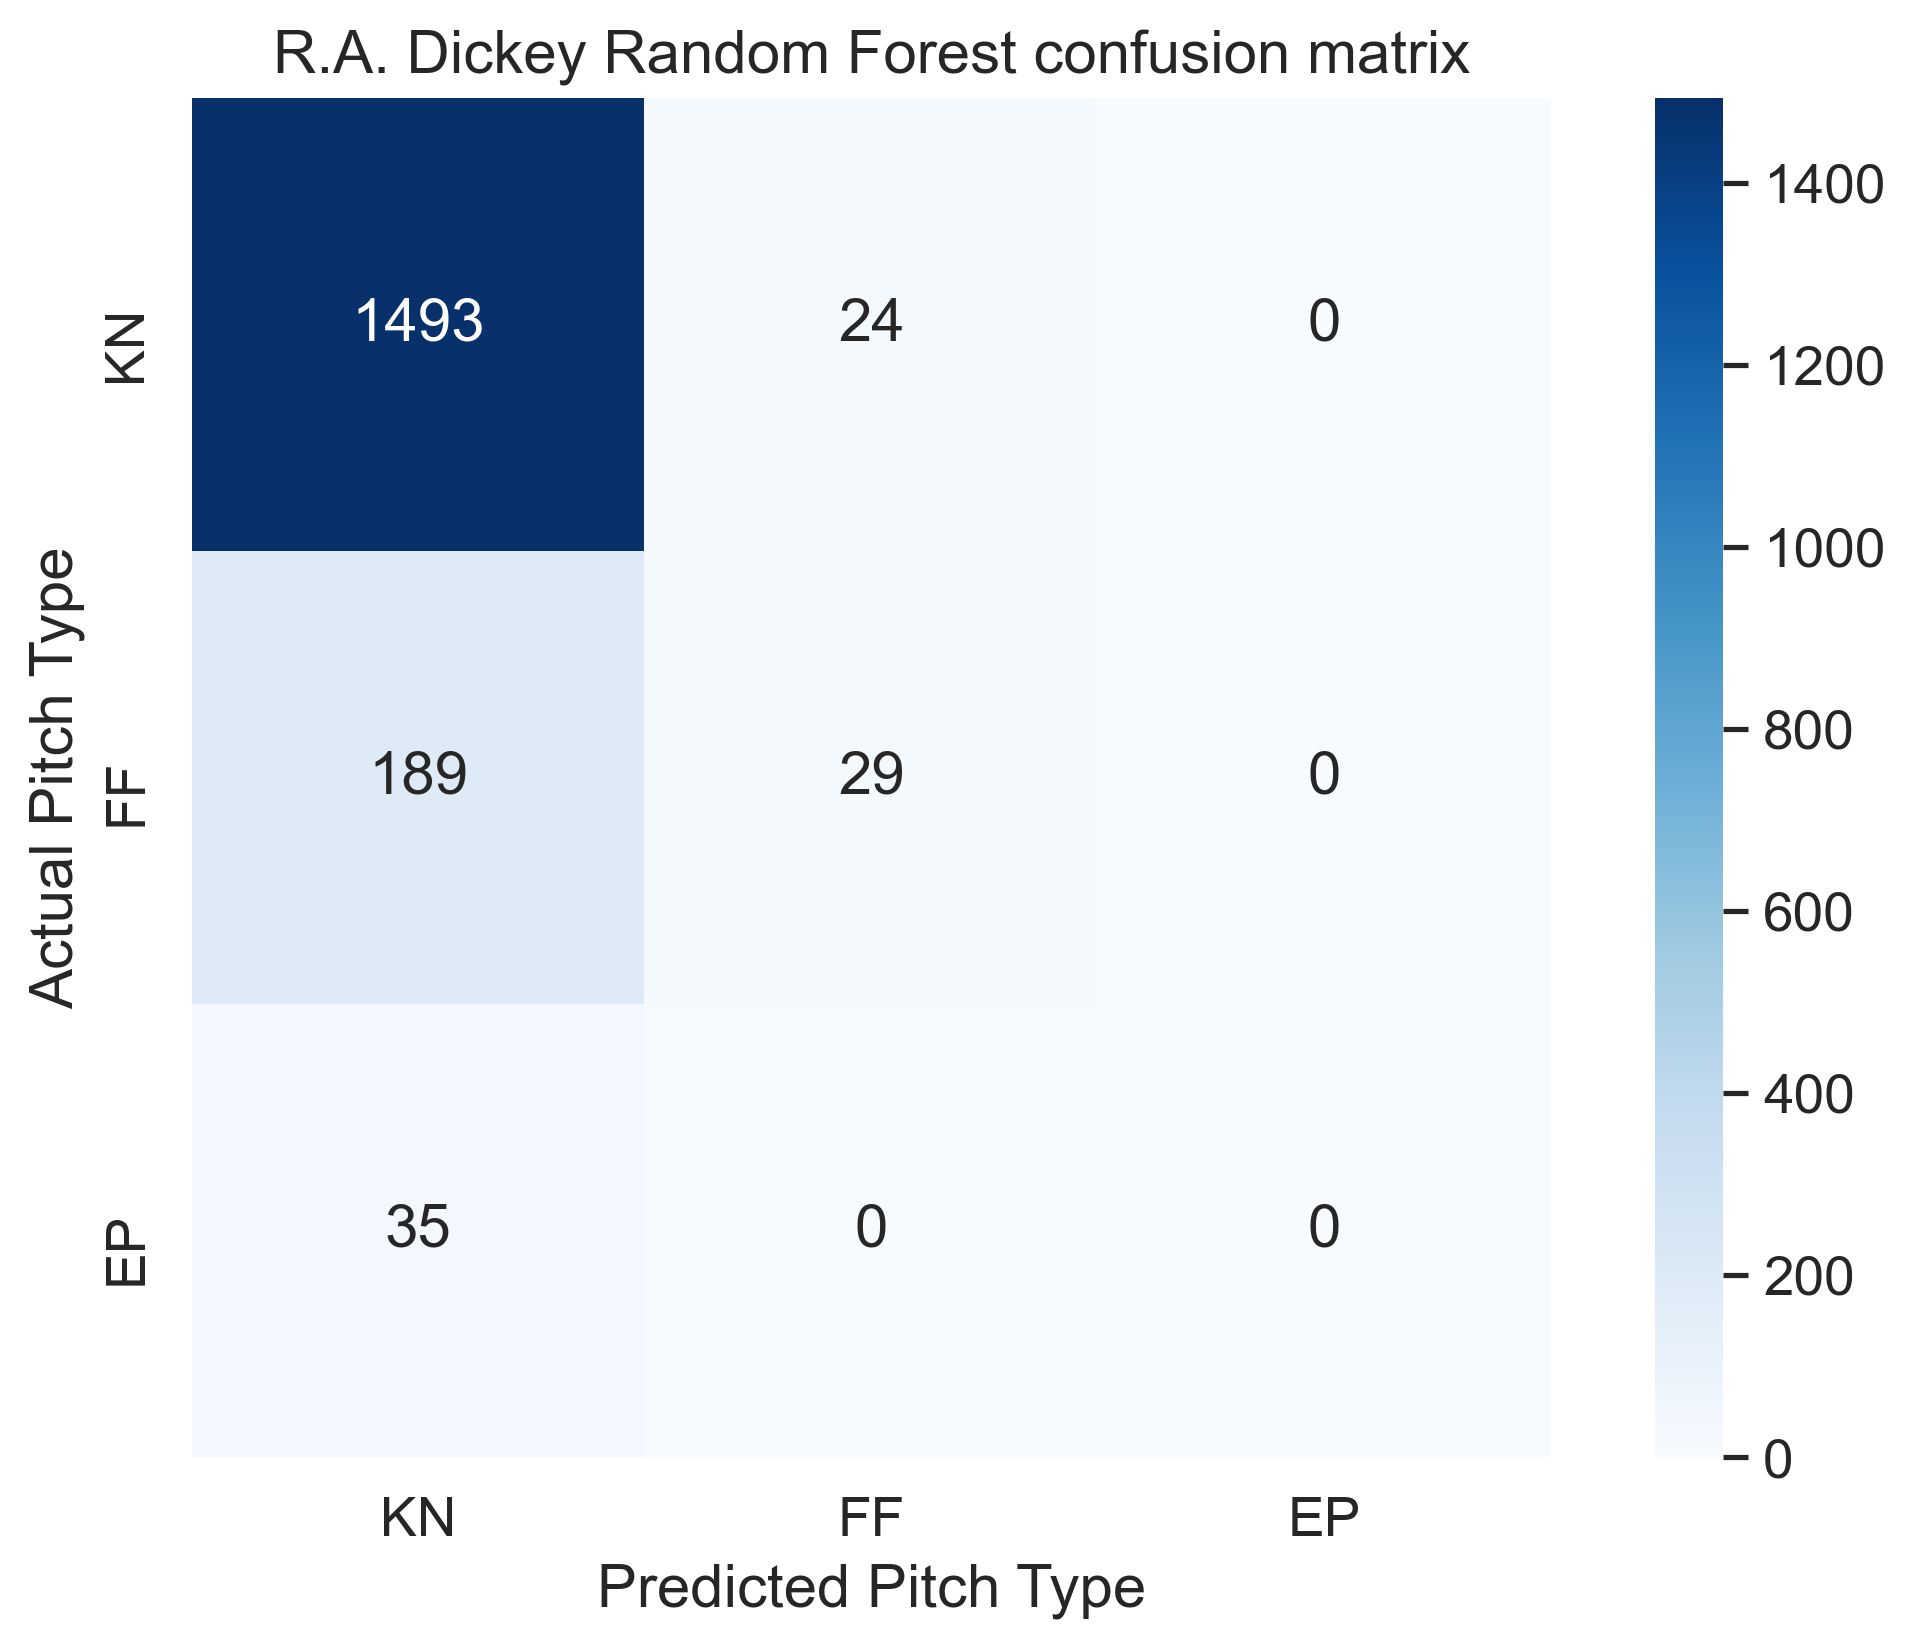

In [44]:
model = random_forest_eval_kfold('R.A. Dickey',X,y, model_df,k=5)

Overall, again it is good with the knuckleball, his primary pitch.  The Four seamer isn't as great as I'd like.  I'm not really concerned with Eephus (EP), as that is a trick pitch where the pitcher throws it in super slow.

### Yu Darvish

Darvish will be another challenge case, as he throws a wide range of pitches.

In [45]:
darvish_df = train_df[(train_df.pitcher_full_name == 'Yu Darvish') & (train_df.last_pitch_pz.notnull())]

In [46]:
new_df = column_ohe_maker(darvish_df, ohe_cols)

In [47]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'FC': 3, 'CU': 4, 'CH': 5, 'FS': 6, 'EP': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
output_df.pitch_type.value_counts()

FF    1964
SL    1257
FT     965
FC     684
CU     328
CH     104
FS      37
EP       5
Name: pitch_type, dtype: int64

In [49]:
output_df.Pitch_Type_Num.value_counts()

0    1964
1    1257
2     965
3     684
4     328
5     104
6      37
7       5
Name: Pitch_Type_Num, dtype: int64

Pitch counts match up, moving to RF modeling.

In [50]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_EP', 'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'Pitch_Type_Num'],
      dtype='object')

In [51]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_speed', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_type_CU', 'last_pitch_type_EP', 'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_SL']

In [52]:
X = output_df[col]

In [53]:
y = output_df['Pitch_Type_Num']

Random Forest Results for Yu Darvish
Confusion Matrix for Fold 1
[[247  73  47  23   5   0   1   0]
 [115  83  31  13   4   0   0   0]
 [ 95  32  53  12   0   0   0   0]
 [ 63  33  22  18   0   0   0   0]
 [ 39  18   3   4   3   0   0   0]
 [ 16   6   2   2   1   1   0   0]
 [  2   1   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0]]


Confusion Matrix for Fold 2
[[250  67  37  13   9   0   0]
 [142  95  21  13   4   0   0]
 [ 96  30  39   8   0   0   2]
 [ 74  23  20  23   2   1   0]
 [ 40  21   5   6   3   0   0]
 [ 11   2   2   1   1   1   0]
 [  3   2   1   1   0   0   0]]


Confusion Matrix for Fold 3
[[240  69  42  21   3   0   0   0]
 [138  88  24  14   6   0   0   0]
 [ 83  34  57  10   0   2   0   0]
 [ 73  22  16  24   1   0   1   0]
 [ 31  27   5   1   2   0   0   0]
 [ 10   7   2   1   0   0   0   0]
 [ 10   3   0   0   0   0   0   0]
 [  0   1   0   0   1   0   0   0]]


Confusion Matrix for Fold 4
[[246  74  42  19   5   0   0]
 [111  84  26  14   1   0   0]
 [1

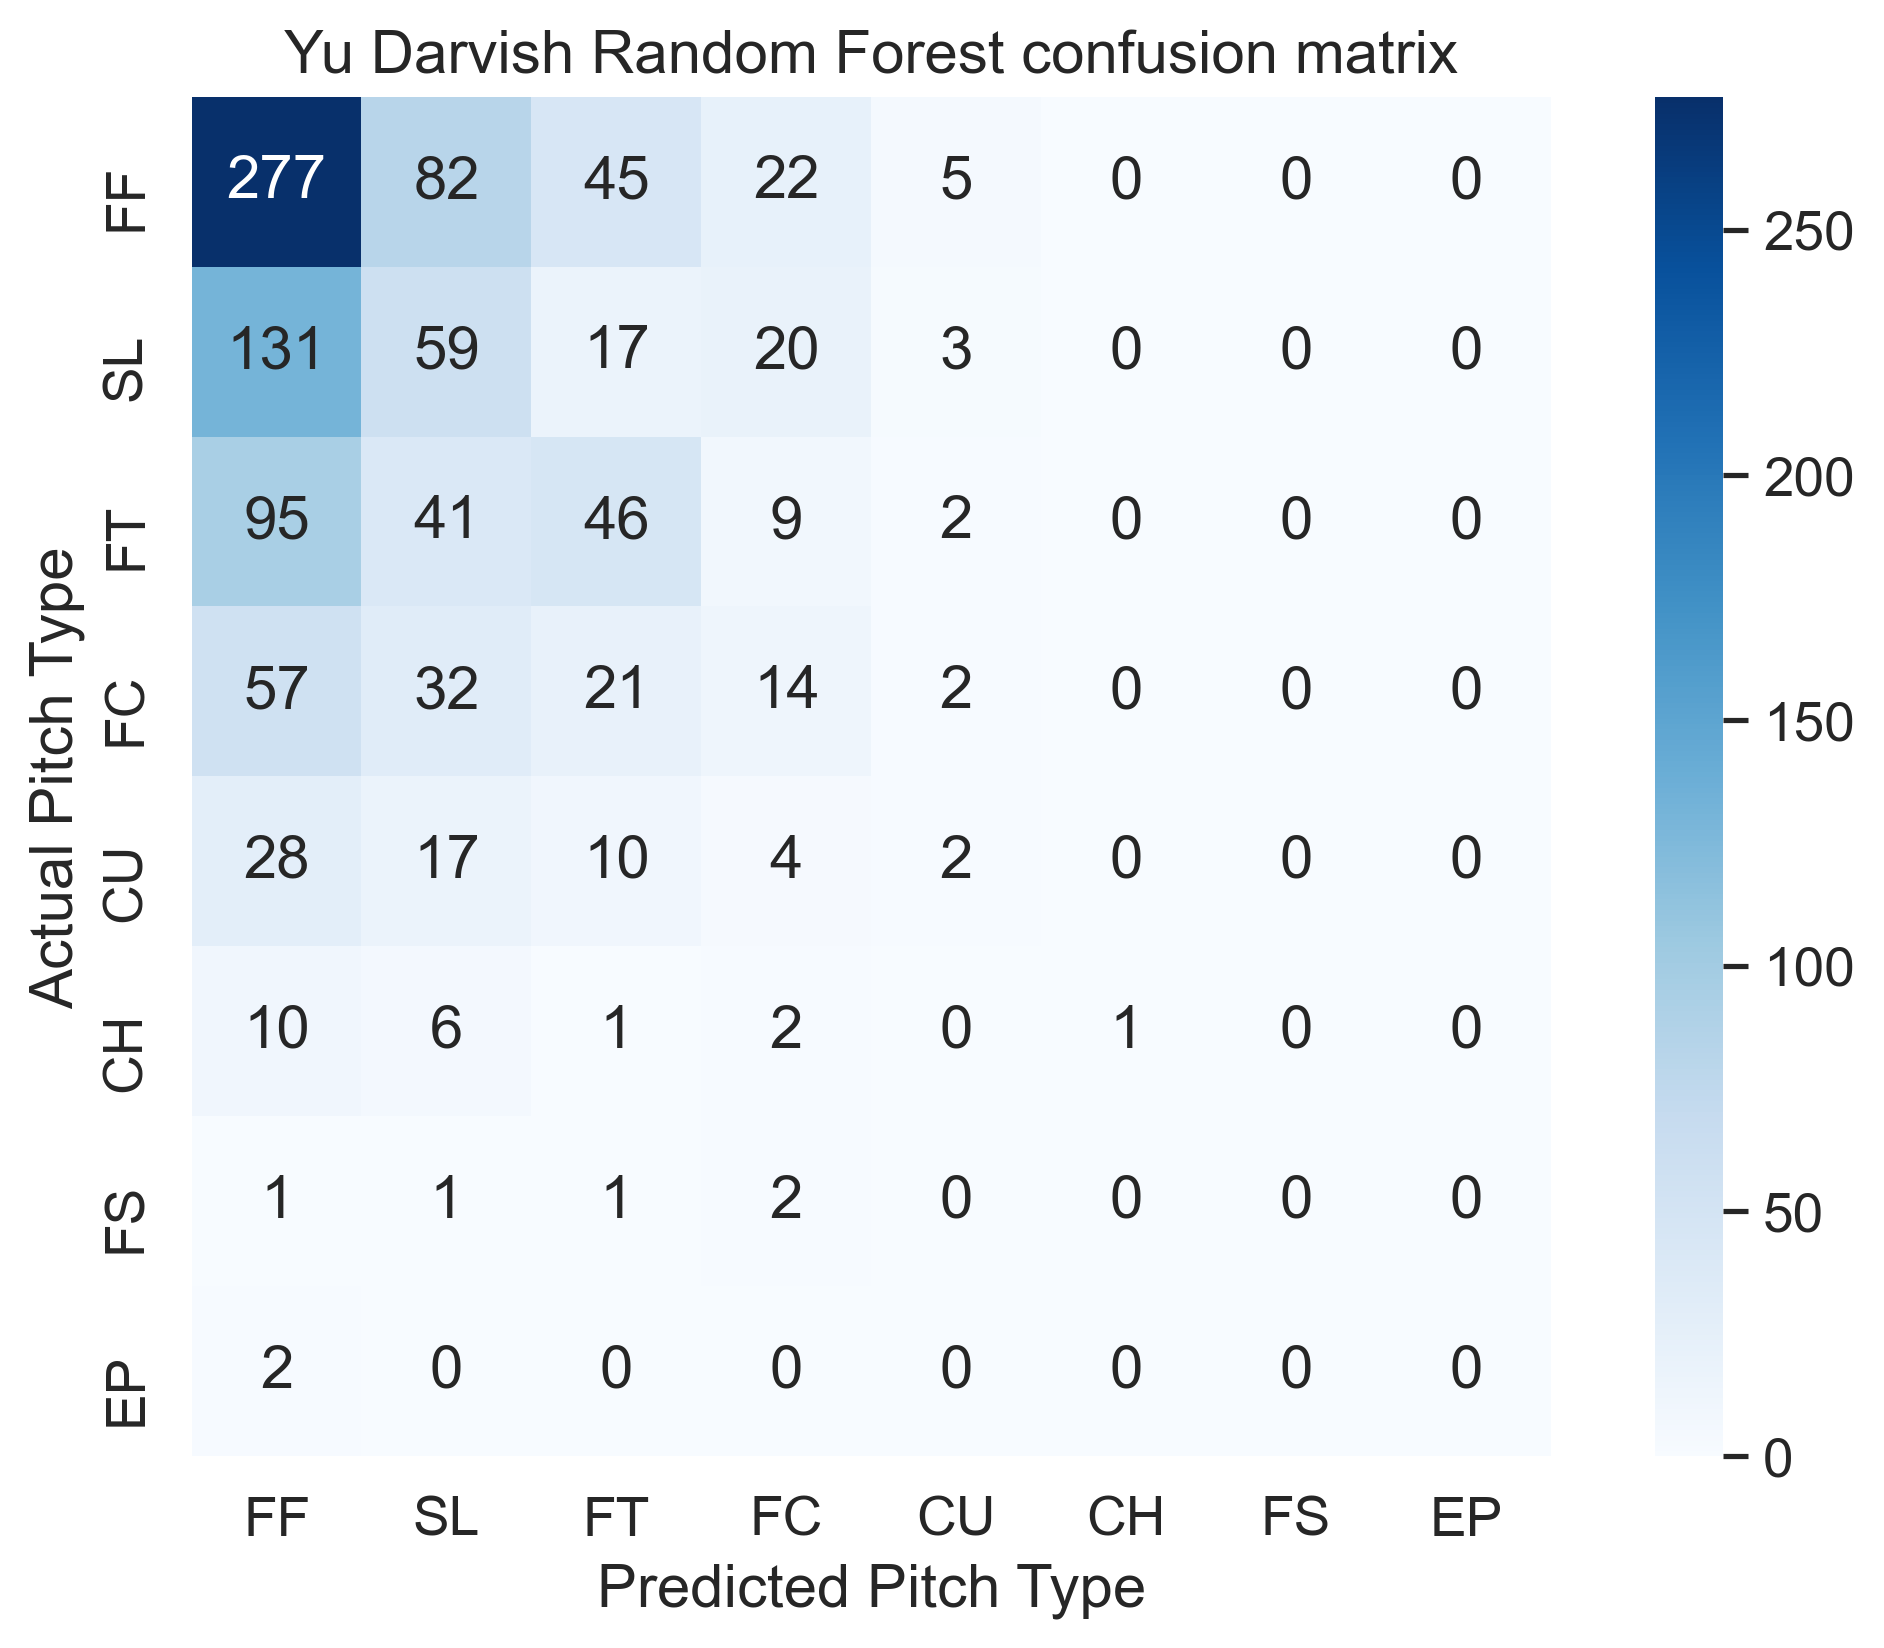

In [54]:
model = random_forest_eval_kfold('Yu Darvish',X,y, output_df,k=5)

The model definitely challenges with Yu Darvish here.  This makes sense, since he throws so many types of pitches.  Once I have the pitch proportions this should improve in performance.

# Adding Pitch Proportions

In [4]:
#Commenting after initial run:
# with open('../Data/full_pitch_df.pickle','rb') as read_file:
#     arsenal_df = pickle.load(read_file)

In [66]:
arsenal_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_ff', 'cumulative_sl',
       'cumulative_ft', 'cumulative_ch', 'cumulative_cu', 'cumulative_si',
       'cumulative_fc', 'cumulative_kc', 'cumulative_fs', 'cumulative_kn',
       'cumulative_ep', 'cumulative_fo', 'cumulative_sc',
       'cumulative_pitches'],
      dtype='object')

In [69]:
arsenal_df[arsenal_df.Season != 2019].tail(15)

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,cumulative_cu,cumulative_si,cumulative_fc,cumulative_kc,cumulative_fs,cumulative_kn,cumulative_ep,cumulative_fo,cumulative_sc,cumulative_pitches
2848356,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,0,0,0,0,0,0,0,0,0,2076
2848357,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,0,0,0,0,0,0,0,0,0,2077
2848358,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2078
2848359,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2079
2848360,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2080
2848361,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2081
2848362,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2082
2848363,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2083
2848364,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2084
2848365,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,0,0,0,0,0,0,0,0,0,2085


In [70]:
train_df.tail(15)

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,pitch_num,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season
2848356,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,3.0,FF,1.064241,3.907686,97.8,Josh Hader,2.0,Ben Zobrist,2018-10-01,2018
2848357,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,4.0,SL,0.676805,3.487355,83.0,Josh Hader,2.0,Ben Zobrist,2018-10-01,2018
2848358,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,1.0,FF,-0.272231,2.628069,97.3,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848359,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,2.0,SL,-0.107080,0.886212,84.3,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848360,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,3.0,FF,0.239849,1.343620,96.3,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848361,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,4.0,FF,1.735599,3.282581,95.5,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848362,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,5.0,FF,0.404748,2.917373,96.2,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848363,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,6.0,FF,0.084721,1.523047,96.4,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848364,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,7.0,FF,-0.599352,1.981704,97.3,Josh Hader,2.0,Javier Baez,2018-10-01,2018
2848365,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,8.0,FF,0.500757,2.783971,97.0,Josh Hader,2.0,Javier Baez,2018-10-01,2018


The indices are identical, which is helpful in merging

Before merging, I want to convert the arsenal_df running counts to rates, so I have a "live" proportion of what pitch types that pitcher has thrown.

In [71]:
train_df.shape

(2848371, 34)

In [72]:
pitch_count_columns = ['cumulative_ff', 'cumulative_sl',
       'cumulative_ft', 'cumulative_ch', 'cumulative_cu', 'cumulative_si',
       'cumulative_fc', 'cumulative_kc', 'cumulative_fs', 'cumulative_kn',
       'cumulative_ep', 'cumulative_fo', 'cumulative_sc']

In [73]:
total_pitches = arsenal_df['cumulative_pitches']
for i, column in enumerate(pitch_count_columns):
    counts = arsenal_df[column]
    rate_name = column + '_' + 'rate'
    arsenal_df[rate_name] = counts / total_pitches
    
#Setting NaN's (i.e. all pitchers first pitches) to 0 for each pitch
for i, pitch_num in enumerate(arsenal_df['cumulative_pitches']):
    if pitch_num == 0:
        arsenal_df.iloc[i, 48:] = 0

In [74]:
arsenal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3555834 entries, 0 to 3555833
Data columns (total 61 columns):
 #   Column              Dtype         
---  ------              -----         
 0   inning              float64       
 1   batter_id           int64         
 2   pitcher_id          int64         
 3   top                 float64       
 4   ab_id               float64       
 5   p_score             float64       
 6   stand               object        
 7   p_throws            object        
 8   event               object        
 9   home_team           object        
 10  away_team           object        
 11  b_score             float64       
 12  on_1b               float64       
 13  on_2b               float64       
 14  on_3b               float64       
 15  px                  float64       
 16  pz                  float64       
 17  zone                object        
 18  pitch_type          object        
 19  start_speed         float64       
 20  ty

In [75]:
arsenal_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_ff', 'cumulative_sl',
       'cumulative_ft', 'cumulative_ch', 'cumulative_cu', 'cumulative_si',
       'cumulative_fc', 'cumulative_kc', 'cumulative_fs', 'cumulative_kn',
       'cumulative_ep', 'cumulative_fo', 'cumulative_sc', 'cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate

In [76]:
arsenal_df.iloc[:, 47:].head(10)

,cumulative_pitches,cumulative_ff_rate,cumulative_sl_rate,cumulative_ft_rate,cumulative_ch_rate,cumulative_cu_rate,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate
0,0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.800000,0.0,0.0,0.0,0.200000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.833333,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.857143,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,8,0.750000,0.0,0.0,0.0,0.125000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0
9,9,0.777778,0.0,0.0,0.0,0.111111,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0


Excellent, this is now ready to merge.

In [77]:
arsenal_df.drop(columns=['cumulative_ff', 'cumulative_sl',
       'cumulative_ft', 'cumulative_ch', 'cumulative_cu', 'cumulative_si',
       'cumulative_fc', 'cumulative_kc', 'cumulative_fs', 'cumulative_kn',
       'cumulative_ep', 'cumulative_fo', 'cumulative_sc'], inplace=True)

In [78]:
arsenal_df[arsenal_df.Season != 2019].shape

(2848371, 48)

In [79]:
train_df.shape

(2848371, 34)

In [80]:
merge_cols = ['cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate']

In [81]:
joined_train_df = train_df.merge(arsenal_df[arsenal_df.Season != 2019][merge_cols], how='left', left_index=True, right_index=True)

# Modeling w/ Updated DF:

### RA Dickey:

I'll start by testing with R.A. Dickey, utilizing the random_forest_pitch_pipeline function from pitch_cat_functions.py:

In [82]:
joined_train_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate'],
      dtype='object')

In [83]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_FF', 'last_pitch_type_KN', 'last_pitch_type_PO',
       'last_pitch_type_None', 'pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

Here is the coding for pitch type:
{'KN': 0, 'FF': 1, 'EP': 2}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for R.A. Dickey
Confusion Matrix for Fold 1
[[1483   13    0]
 [ 215   21    0]
 [  38    0    0]]


Confusion Matrix for Fold 2
[[1473   20    0]
 [ 205   32    0]
 [  40    0    0]]


Confusion Matrix for Fold 3
[[1448   20    0]
 [ 233   25    0]
 [  44    0    0]]


Confusion Matrix for Fold 4
[[1463   17    0]
 [ 219   25    0]
 [  46    0    0]]


Confusion Matrix for Fold 5
[[1493   24    0]
 [ 189   29    0]
 [  35    0    0]]




RandomForestClassifier()

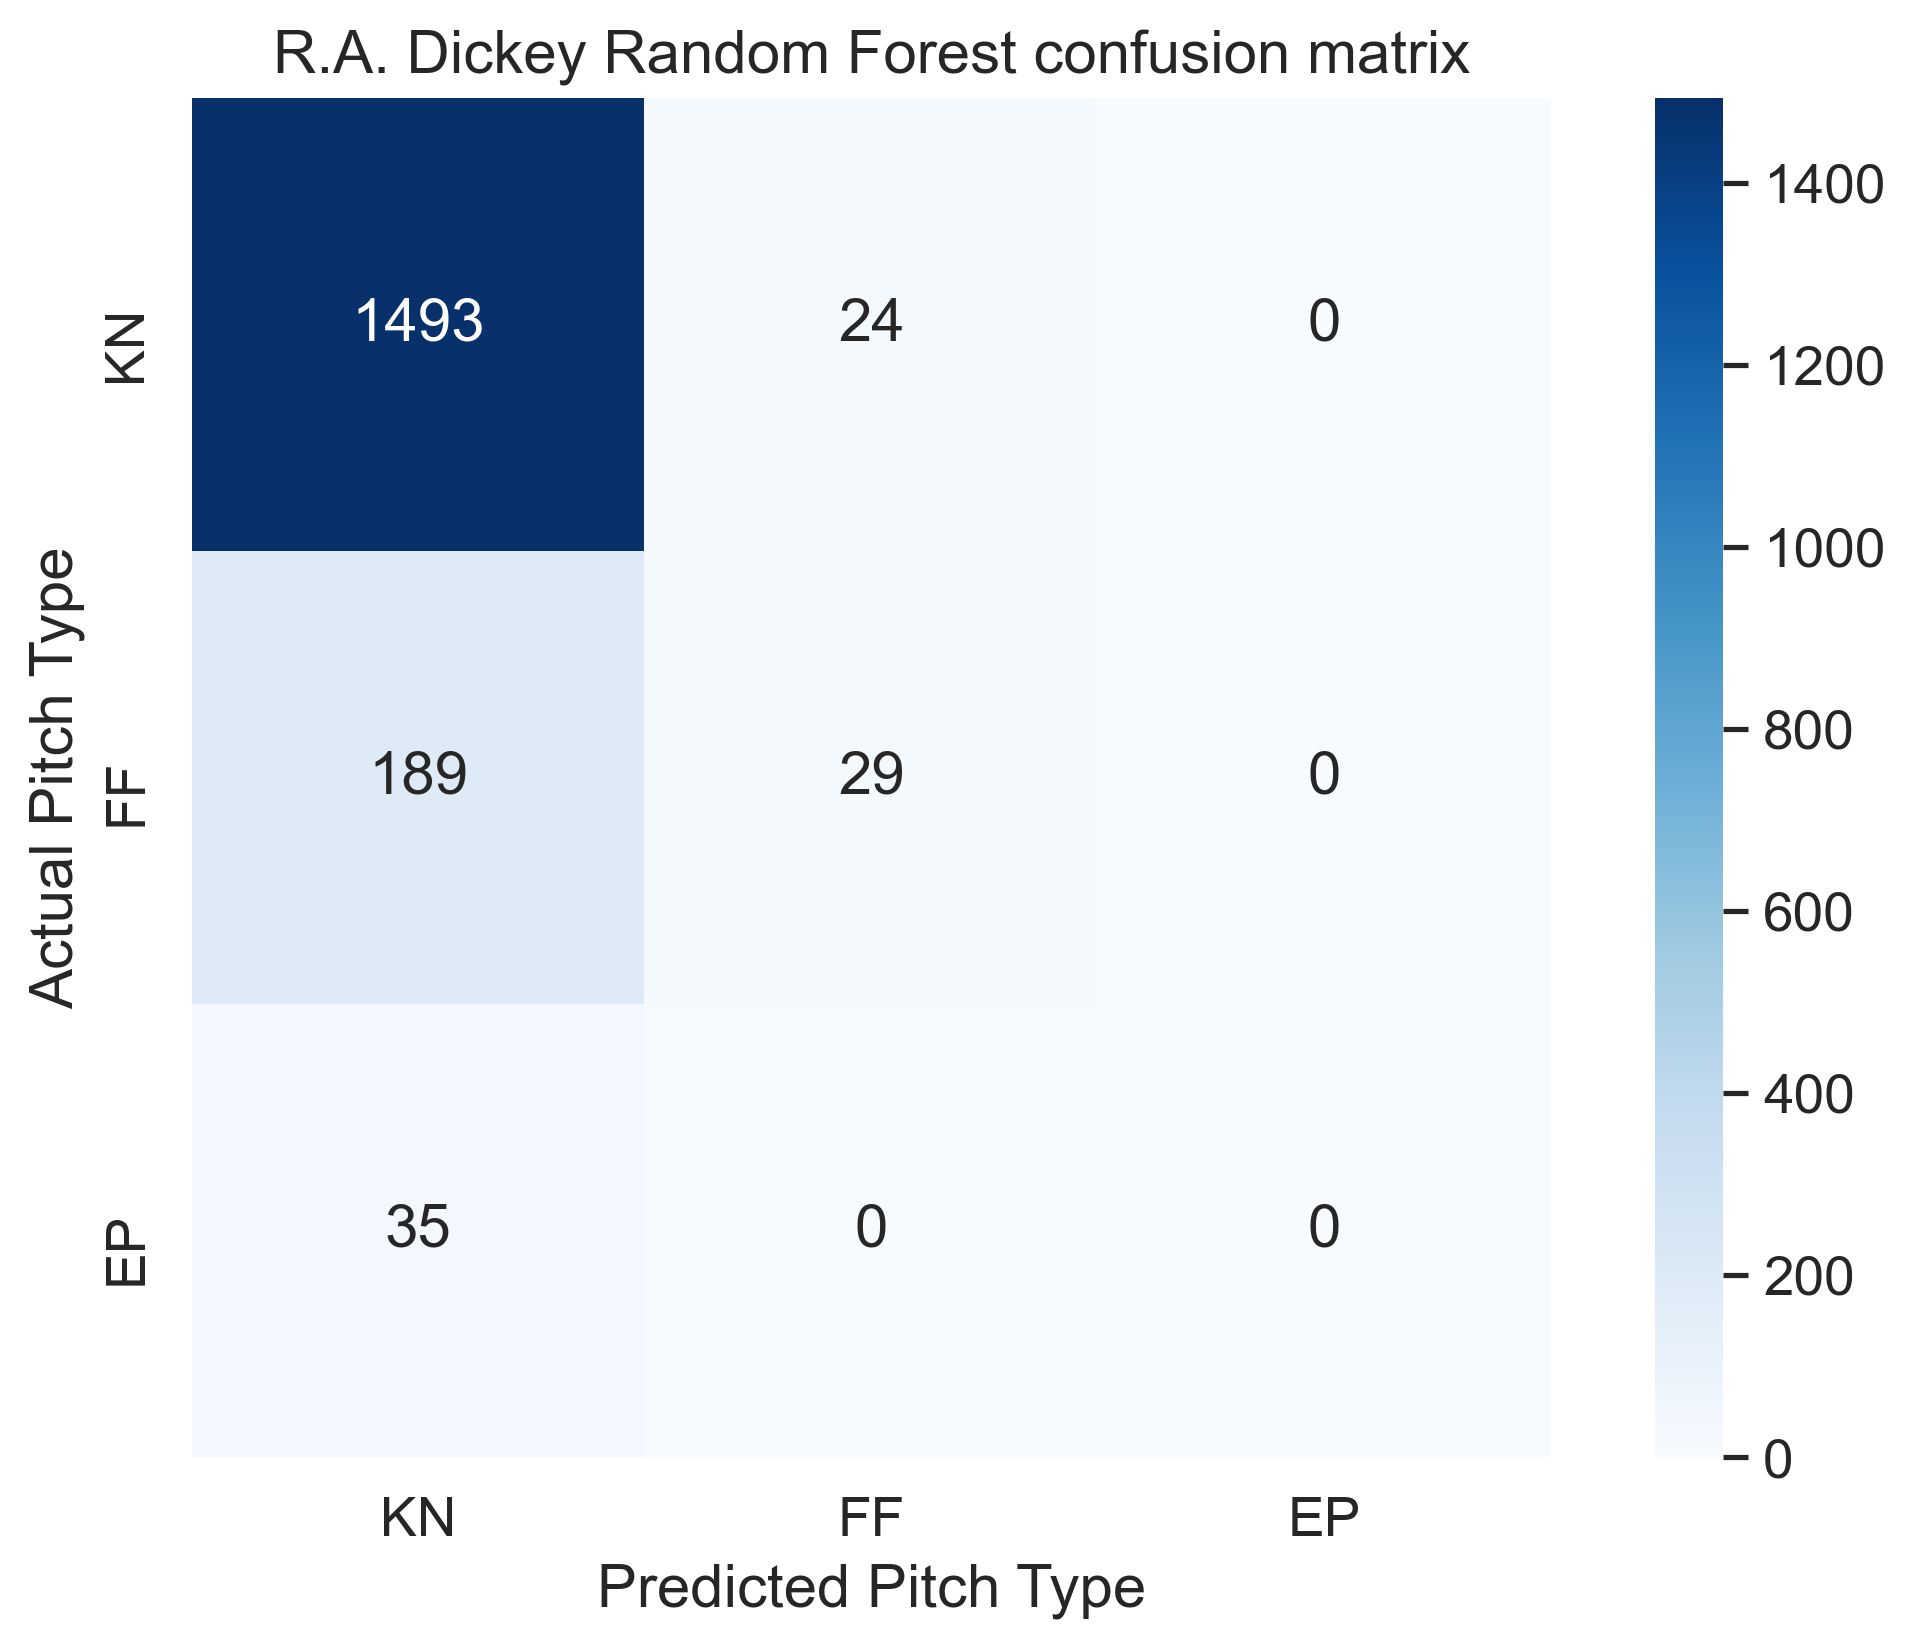

In [84]:
random_forest_pitch_pipeline('R.A. Dickey', joined_train_df, ohe_cols, col, k=5)

### Max Scherzer:

Next test with Max Scherzer:

In [85]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz','pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for Max Scherzer
Confusion Matrix for Fold 1
[[1160  148   51   13   18    1]
 [ 427  121   12    0    0    1]
 [ 315   15   19    8    7    0]
 [ 193    2    6    5    5    0]
 [ 134    0    7    2    2    0]
 [  11    5    2    2    1    1]]


Confusion Matrix for Fold 2
[[1208  164   43   14   13    1]
 [ 331  143    9    2    0    0]
 [ 312   52   23    3   10    1]
 [ 173    9   10    6    3    2]
 [ 117    2   11    3    6    0]
 [  16    5    0    0    0    1]]


Confusion Matrix for Fold 3
[[1205  151   39   12   19    2]
 [ 338  155   12    3    1    1]
 [ 313   34   17    4    6    0]
 [ 206    6   10    5    2    0]
 [ 117    1   10    1    6    0]
 [   9    8    0    0    0    0]]


Confusion Matrix for Fold 4
[[1169  164   46   17   18    1]
 [ 411  136   10    0    0    0]
 [ 309   32   19    5    4    1]
 [ 178    9   11    6    3    0]
 [ 112    3   12    1    3    0]
 [   5    4    1    1    0    2]]


Confusion Matrix for Fold 5
[[1222  124   50 

RandomForestClassifier()

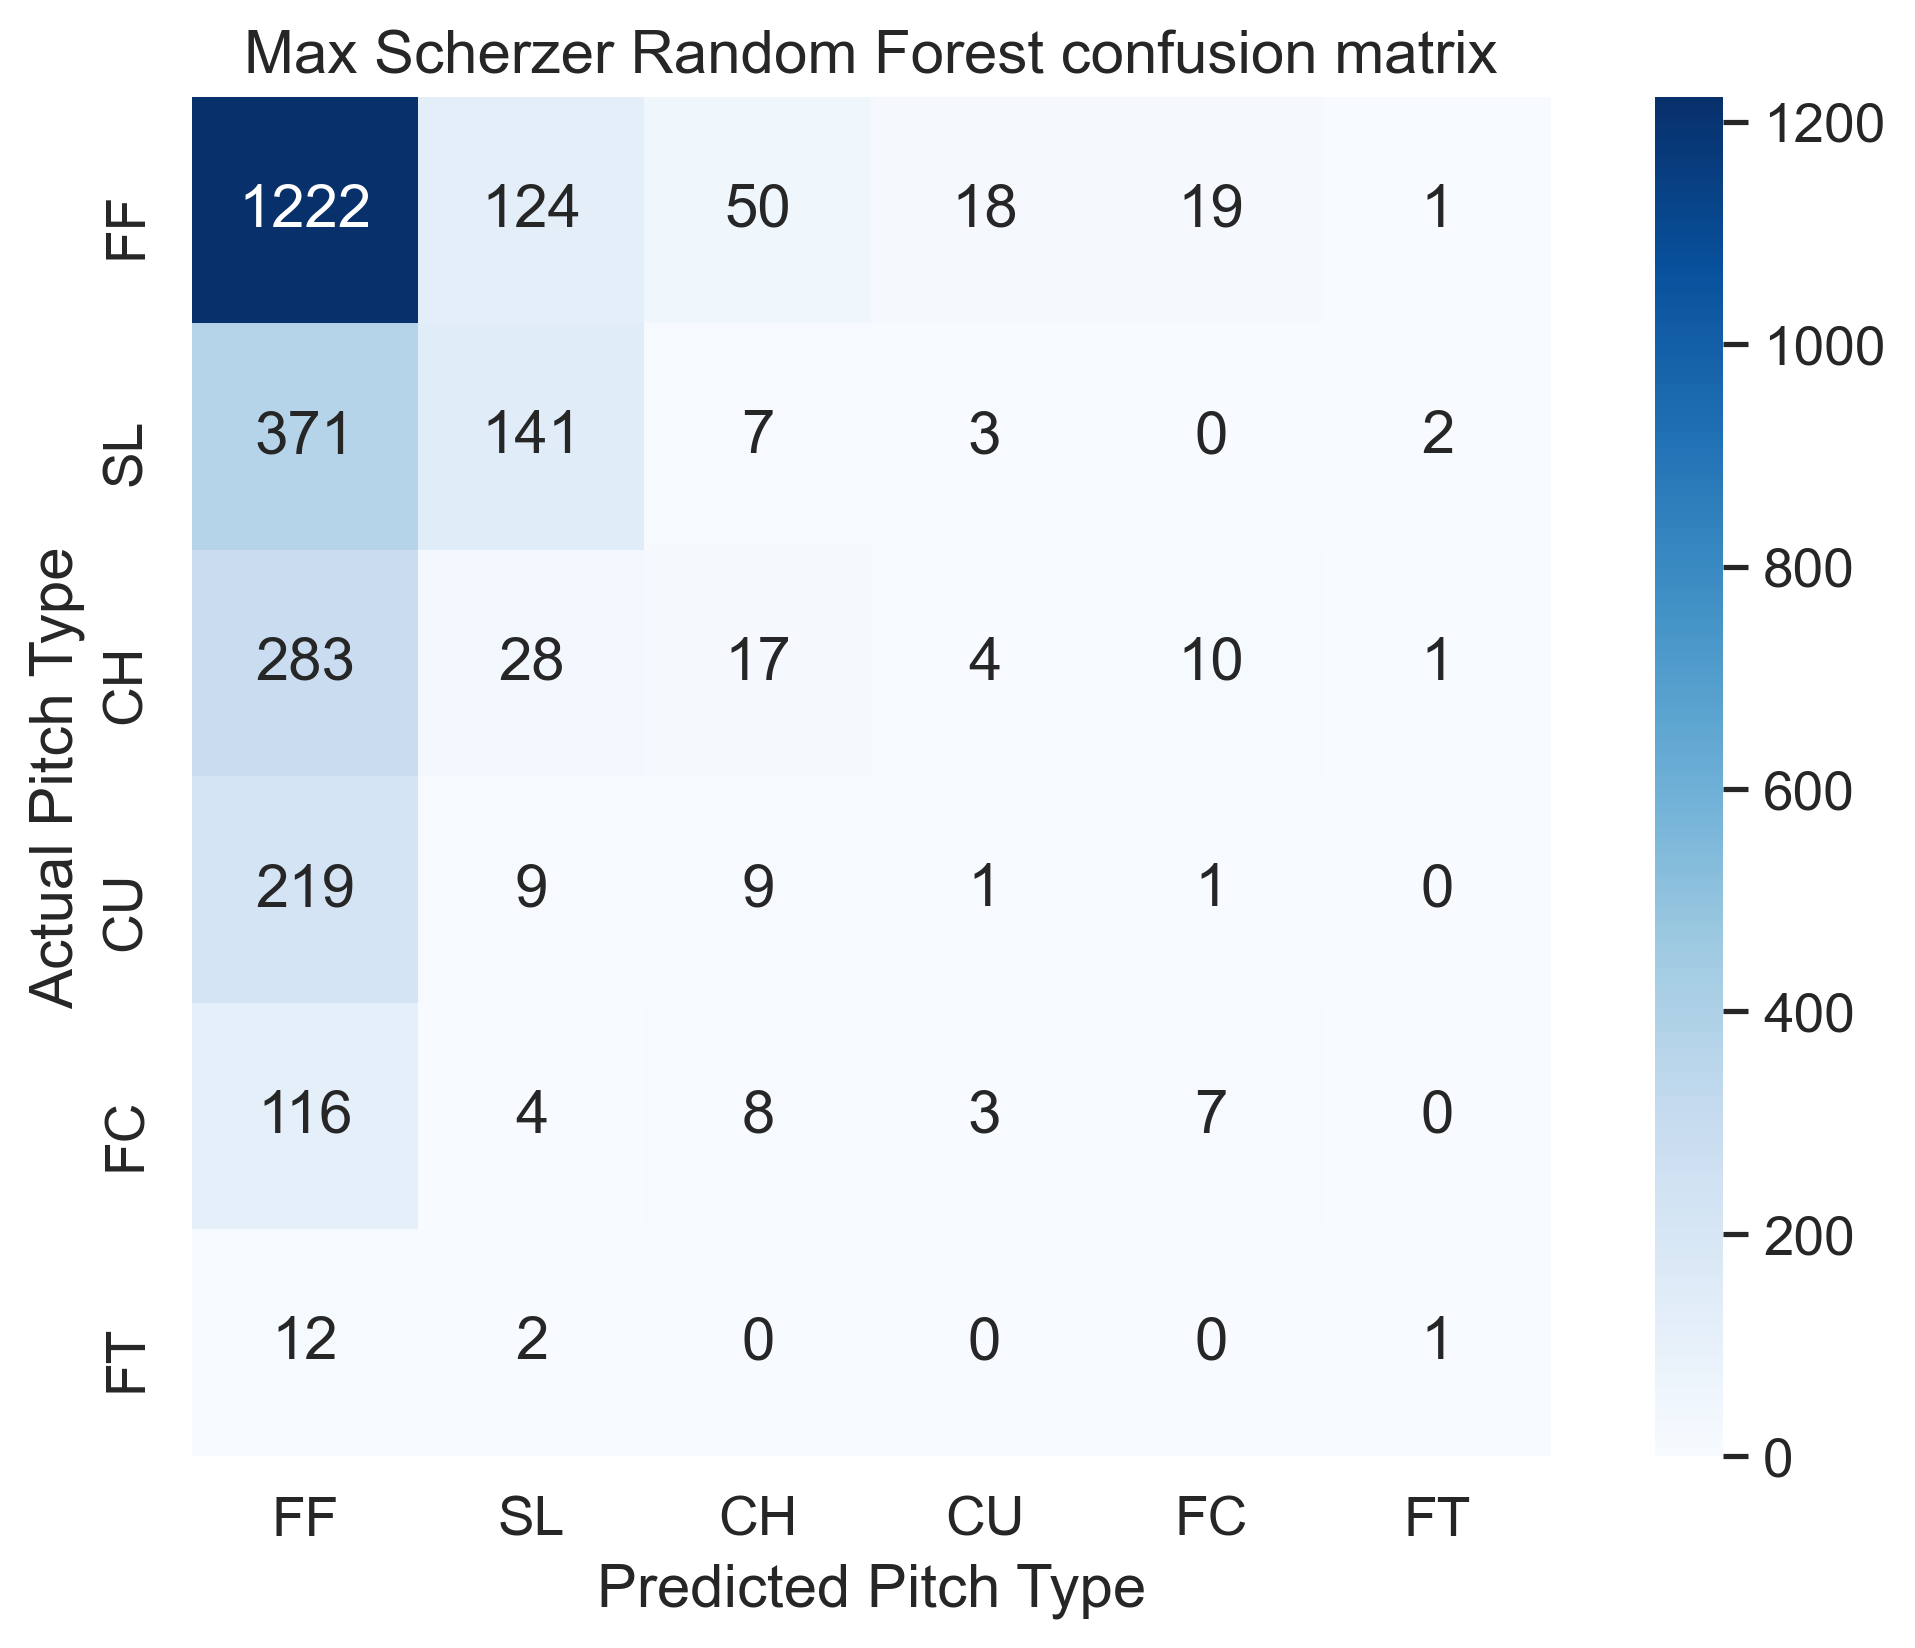

In [86]:
random_forest_pitch_pipeline('Max Scherzer', joined_train_df, ohe_cols, col, k=5)

Overall, it is performing well on the pitcher's primary pitch, but not as much on the lesser-thrown pitches.

## Batter Clusters:

One other feature I was looking to bring on was the hitter clusters from notebook Batter_Clustering in the Clustering folder.  I'll test that out here:

Plickling in the clusters:

In [87]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [33]:
with open('../Data/batter_clusters/cluster_assignments.pickle','rb') as read_file:
    clusters_df = pickle.load(read_file)

In [34]:
clusters_df

,Name,Cluster
0,Luis Arraez,3
1,Jose Altuve,3
2,Jeff McNeil,1
3,Fernando Tatis Jr.,0
4,Bryan Reynolds,0
...,...,...
914,Jordan Lyles,2
915,Matt Garza,2
916,Anibal Sanchez,2
917,Chad Bettis,2


In [107]:
joined_train_df.shape

(2848371, 48)

Merging the clusters onto the train df:

In [112]:
train_df_clusters = joined_train_df.merge(clusters_df.drop_duplicates(subset=['Name']), how='left', left_on='hitter_full_name', right_on='Name')

In [113]:
train_df_clusters.shape

(2848371, 50)

In [114]:
train_df_clusters.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate,Name,Cluster
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
1,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
2,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
3,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0
4,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matt Carpenter,0.0


In [115]:
train_df_clusters.isnull().sum()

inning                    0
batter_id                 0
pitcher_id                0
top                       0
ab_id                     0
p_score                   0
stand                     0
p_throws                  0
event                     0
home_team                 0
away_team                 0
b_score                   0
on_1b                     0
on_2b                     0
on_3b                     0
px                        0
pz                        0
zone                      0
pitch_type                0
start_speed               0
type                      0
b_count                   0
s_count                   0
outs                      0
pitch_num                 0
last_pitch_type        3232
last_pitch_px          3232
last_pitch_pz          3232
last_pitch_speed       3214
pitcher_full_name         0
pitcher_run_diff          0
hitter_full_name          0
Date_Time_Date            0
Season                    0
cumulative_pitches        0
cumulative_ff_rate  

For all the players who weren't assigned a cluster, that is because they did not have 100 plate appearances.  Thus, they likely do not have enough PA's to have a distinct track record, so I will assign them to cluster 4.0, as a placeholder to not lose the rows.

In [116]:
train_df_clusters.Cluster.value_counts()

3.0    1114561
0.0    1010923
1.0     599491
2.0      40118
Name: Cluster, dtype: int64

In [117]:
train_df_clusters.Cluster.fillna(value=4.0, inplace=True)

In [118]:
train_df_clusters.Cluster.value_counts()

3.0    1114561
0.0    1010923
1.0     599491
4.0      83278
2.0      40118
Name: Cluster, dtype: int64

Dropping out the hitter name, since it is already in hitter_full_name:

In [119]:
train_df_clusters.drop(columns=['Name'], inplace=True)

Pickling out this dataframe:

In [121]:
with open('../Data/train_df_clusters.pickle', 'wb') as to_write:
    pickle.dump(train_df_clusters, to_write)

Now, going into modeling.

### Max Scherzer:

Next test with Max Scherzer:

In [73]:
merged_test_df.tail()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,cumulative_ch_rate,cumulative_cu_rate,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate
707458,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707459,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707460,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707461,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707462,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
col = ['Cluster','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'pitcher_run_diff','last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None','last_pitch_speed', 'last_pitch_px', 'last_pitch_pz','pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for Max Scherzer
Confusion Matrix for Fold 1
[[1162  153   53    9   14    0]
 [ 402  145   12    0    1    1]
 [ 318   16   18    4    8    0]
 [ 190    4    8    5    4    0]
 [ 123    1   12    2    7    0]
 [  12    5    1    2    1    1]]


Confusion Matrix for Fold 2
[[1193  171   41   20   17    1]
 [ 342  133    7    2    1    0]
 [ 315   53   18    4   10    1]
 [ 178    7   10    3    2    3]
 [ 118    1   12    3    5    0]
 [  14    6    0    1    0    1]]


Confusion Matrix for Fold 3
[[1186  162   51   11   16    2]
 [ 329  162   14    2    1    2]
 [ 313   32   22    2    4    1]
 [ 203    3   14    7    2    0]
 [ 114    3   10    0    8    0]
 [   8    8    1    0    0    0]]


Confusion Matrix for Fold 4
[[1163  164   54   10   23    1]
 [ 419  125   12    1    0    0]
 [ 296   33   26    6    9    0]
 [ 178    9   11    5    4    0]
 [ 110    4   12    2    3    0]
 [   6    4    1    0    0    2]]


Confusion Matrix for Fold 5
[[1204  147   53 

RandomForestClassifier()

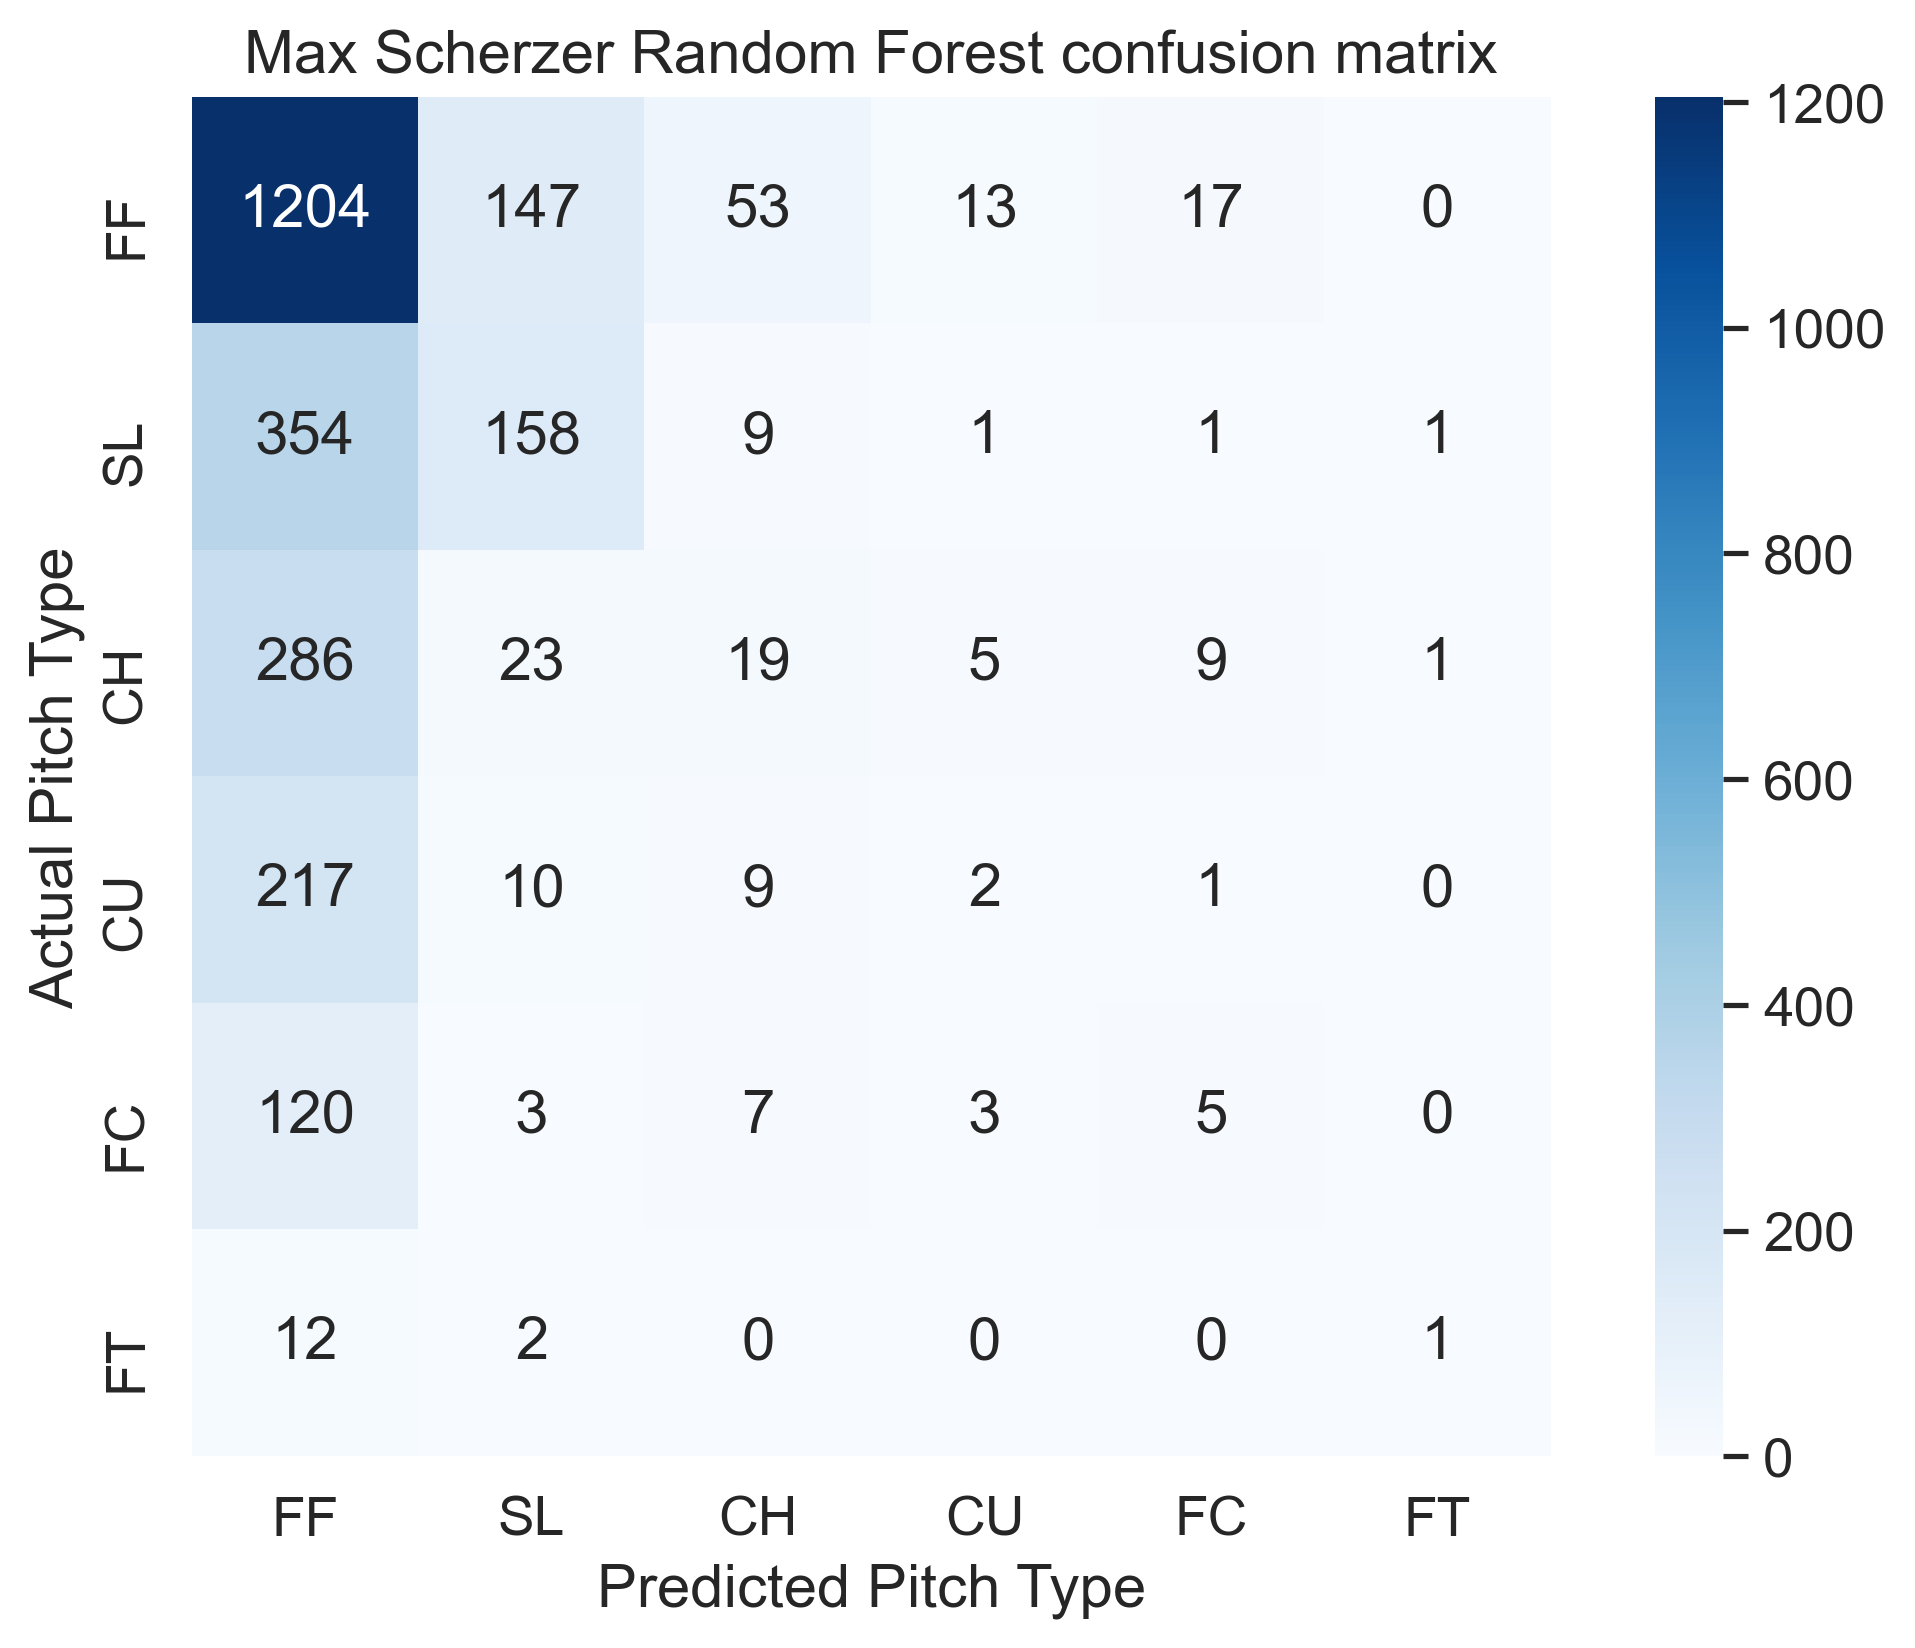

In [123]:
random_forest_pitch_pipeline('Max Scherzer', train_df_clusters, ohe_cols, col, k=5)

### RA Dickey:

Here is the coding for pitch type:
{'KN': 0, 'FF': 1, 'EP': 2}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for R.A. Dickey
Confusion Matrix for Fold 1
[[1484   12    0]
 [ 212   24    0]
 [  38    0    0]]


Confusion Matrix for Fold 2
[[1470   23    0]
 [ 211   26    0]
 [  40    0    0]]


Confusion Matrix for Fold 3
[[1448   20    0]
 [ 232   26    0]
 [  44    0    0]]


Confusion Matrix for Fold 4
[[1461   19    0]
 [ 213   31    0]
 [  46    0    0]]


Confusion Matrix for Fold 5
[[1492   25    0]
 [ 189   29    0]
 [  35    0    0]]




RandomForestClassifier()

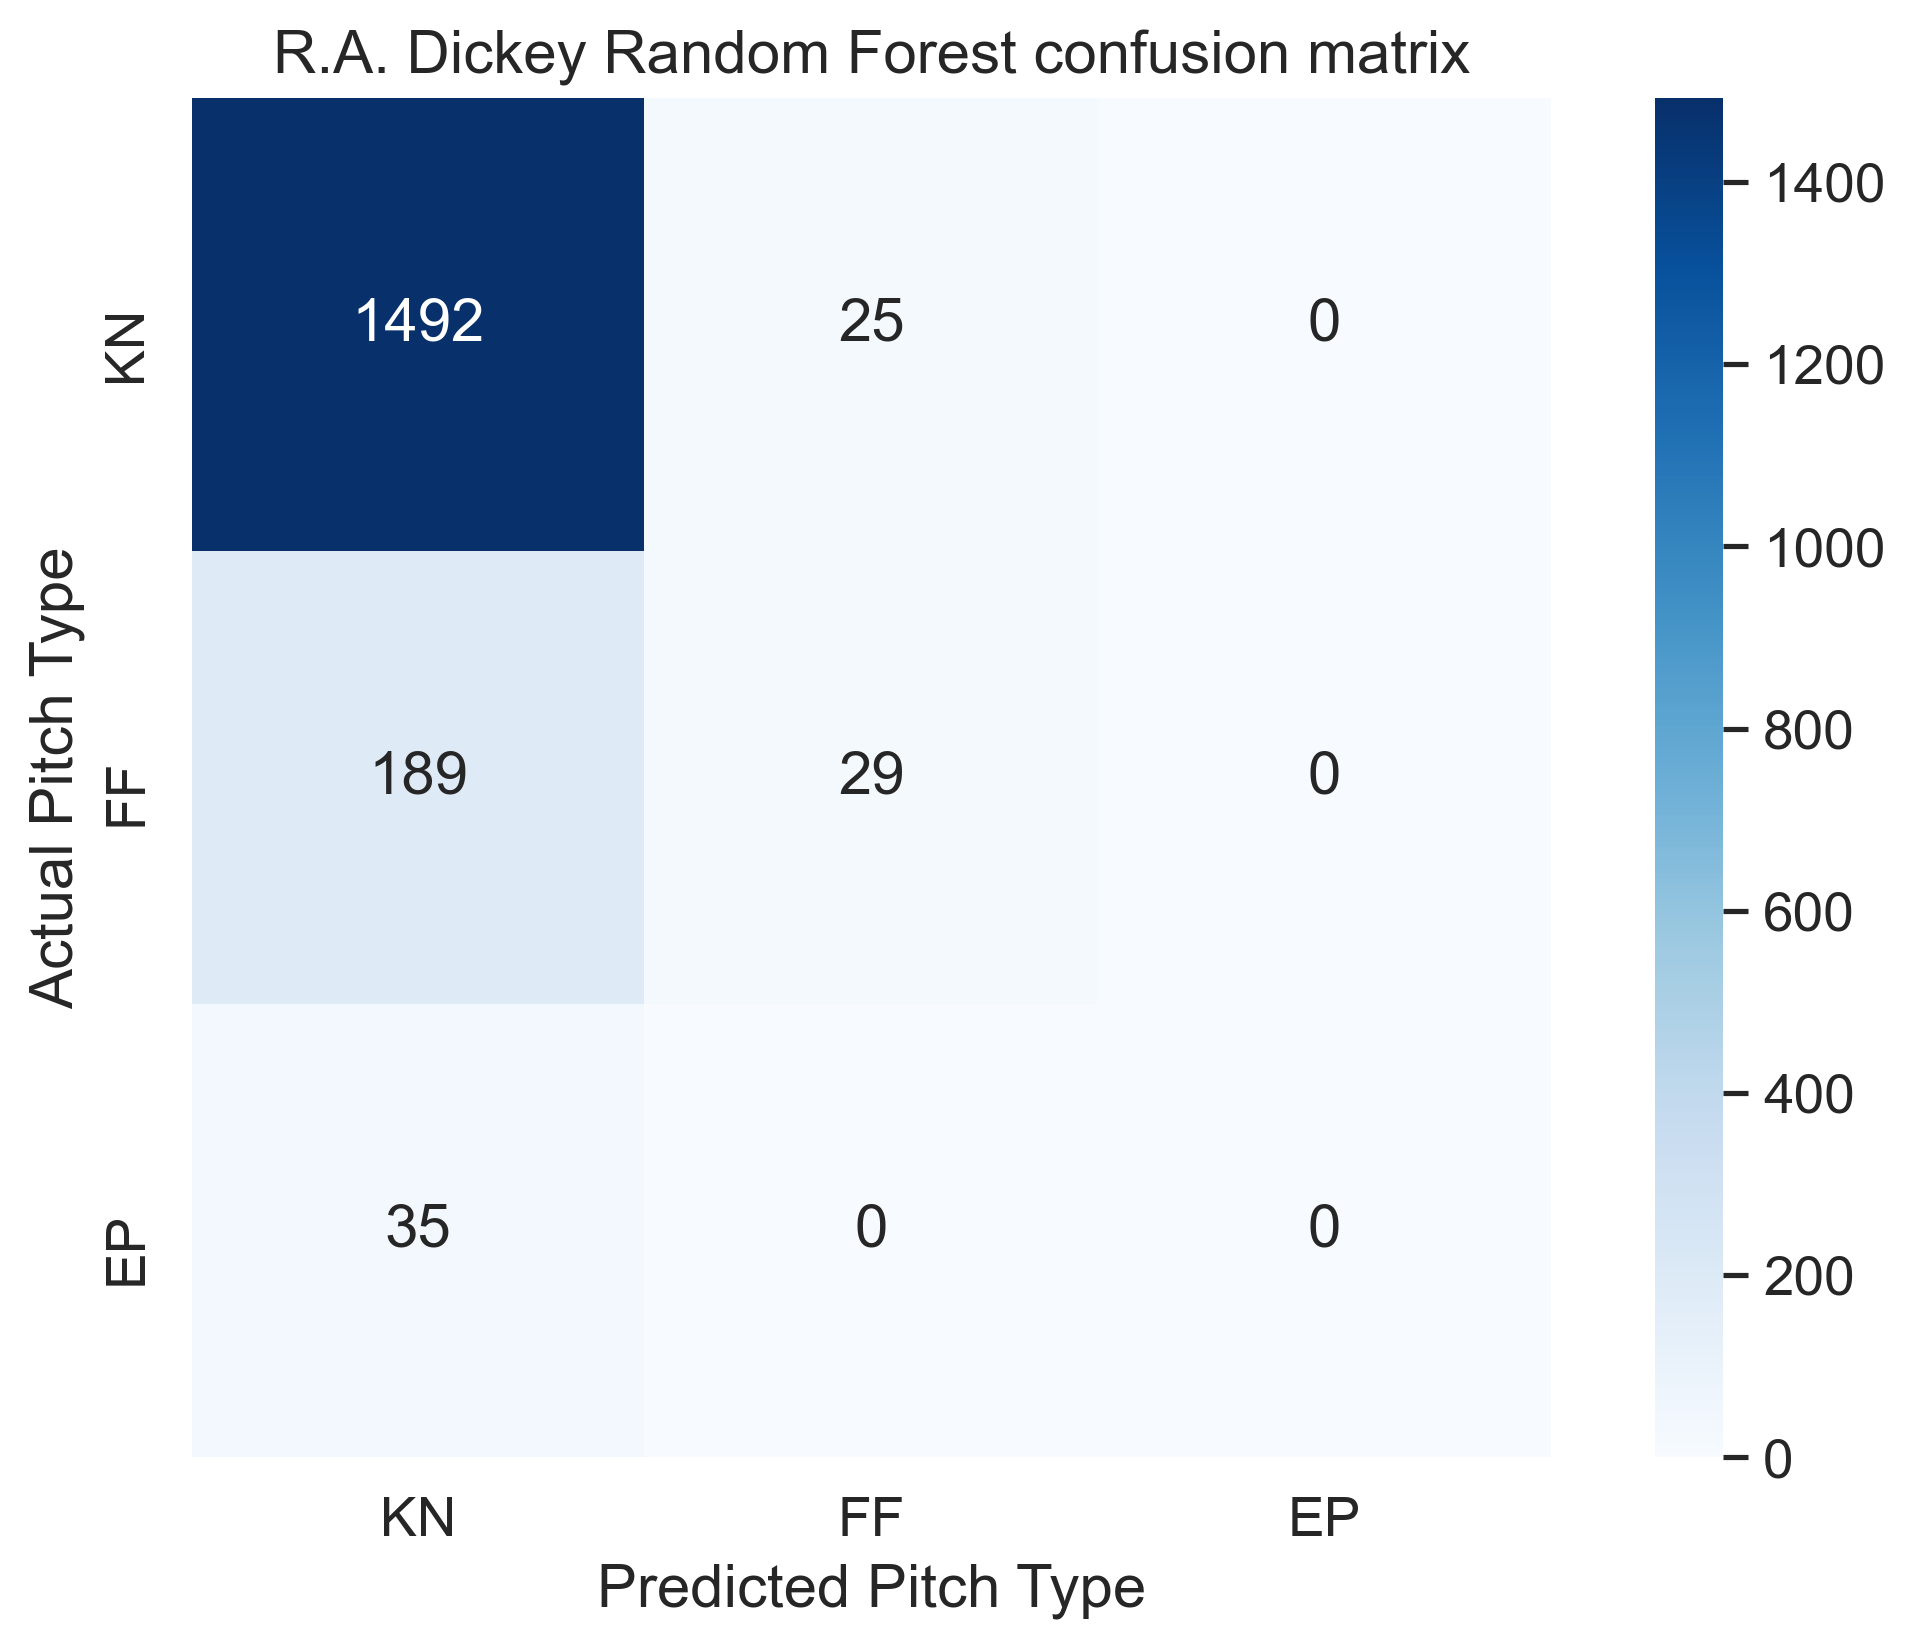

In [124]:
col = ['Cluster','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_FF',
       'pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

random_forest_pitch_pipeline('R.A. Dickey', train_df_clusters, ohe_cols, col, k=5)

### Clayton Kershaw:

As another test, I'll try this out on Clayton Kershaw.

In [125]:
kershaw_df = train_df_clusters[train_df_clusters.pitcher_full_name == 'Clayton Kershaw'].last_pitch_type.value_counts()

In [126]:
kershaw_df = train_df_clusters[train_df_clusters.pitcher_full_name == 'Clayton Kershaw']

In [127]:
ohe_cols

['stand', 'p_throws', 'last_pitch_type']

In [128]:
df = column_ohe_maker(kershaw_df, ohe_cols)

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CU': 2, 'FT': 3, 'CH': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Random Forest Results for Clayton Kershaw
Confusion Matrix for Fold 1
[[680 208  71   0   0]
 [386 244  82   0   0]
 [167  83  82   1   0]
 [ 14   5   6   2   0]
 [  4   3  11   0   0]]


Confusion Matrix for Fold 2
[[711 232  68   1   0]
 [353 254  57   2   0]
 [131 106  89   1   0]
 [ 24   5   3   2   0]
 [  6   2   2   0   0]]


Confusion Matrix for Fold 3
[[680 204  80   3   0]
 [366 263  68   1   0]
 [152  99  95   0   0]
 [ 19   3   6   1   0]
 [  3   4   1   0   0]]


Confusion Matrix for Fold 4
[[711 193  63   1   0]
 [381 256  61   0   0]
 [149 121  72   0   0]
 [ 23   3   2   1   0]
 [  2   2   7   0   0]]


Confusion Matrix for Fold 5
[[692 208  65   0   0]
 [329 267  61   1   0]
 [165 118 104   0   0]
 [ 22   5   5   2   0]
 [  2   2   0   0   0]]




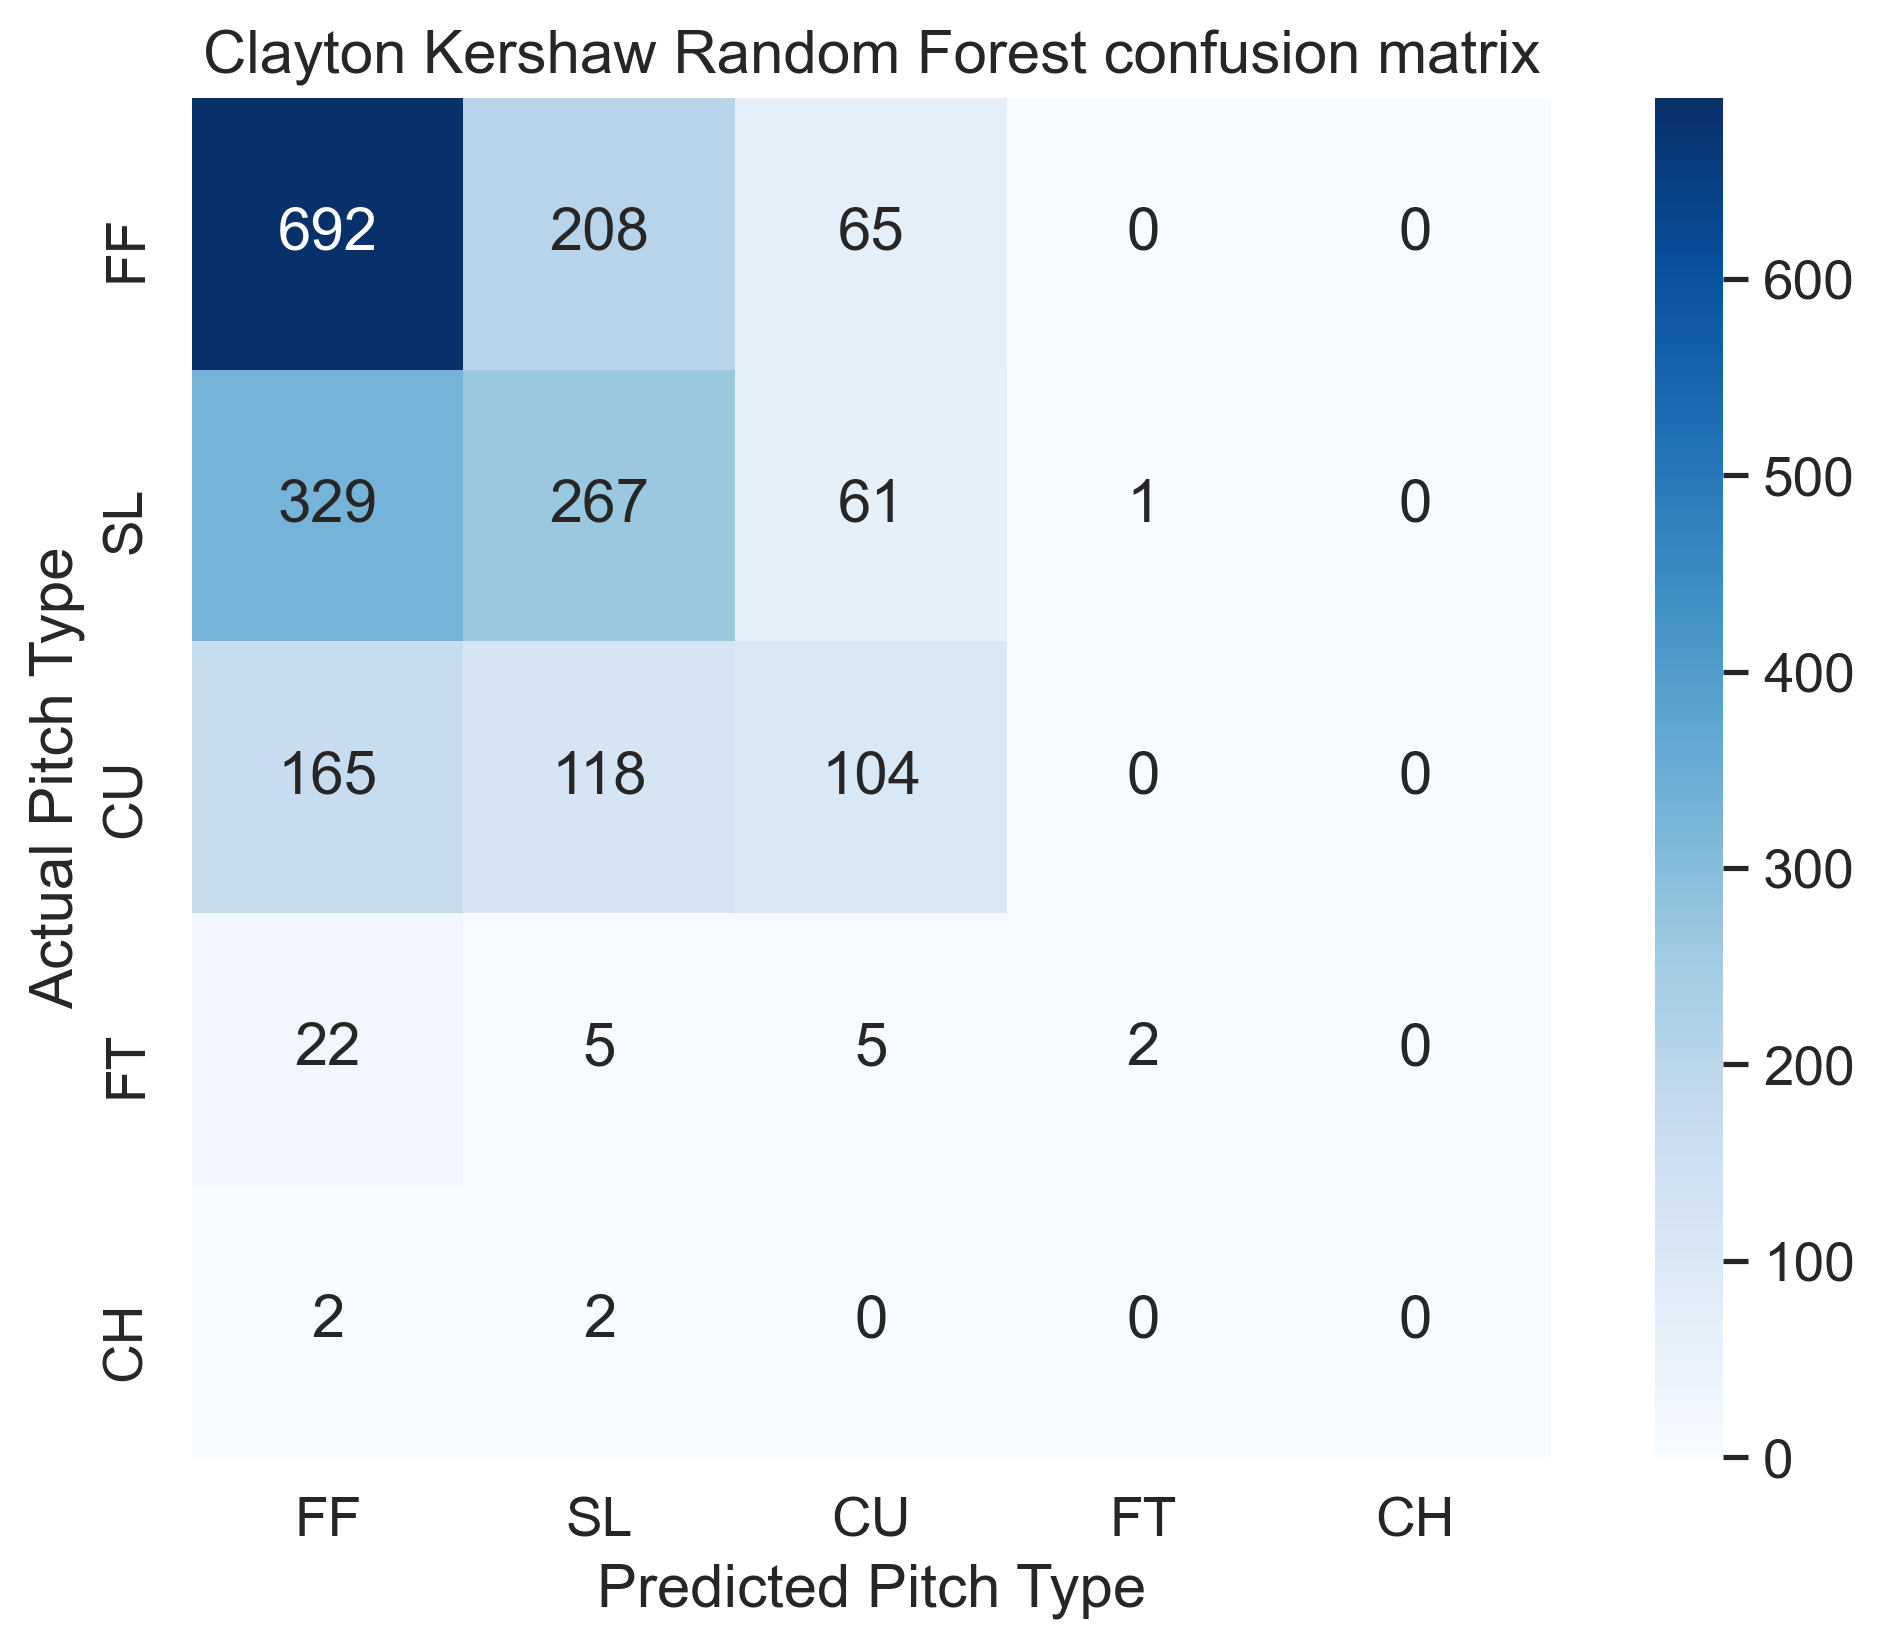

In [129]:
col = ['Cluster','inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_px', 'last_pitch_speed', 'last_pitch_pz', 'pitcher_run_diff',
       'last_pitch_type_CU', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_None', 'pitch_num','cumulative_pitches',
       'cumulative_ff_rate', 'cumulative_sl_rate', 'cumulative_ft_rate',
       'cumulative_ch_rate', 'cumulative_cu_rate', 'cumulative_si_rate',
       'cumulative_fc_rate', 'cumulative_kc_rate', 'cumulative_fs_rate',
       'cumulative_kn_rate', 'cumulative_ep_rate', 'cumulative_fo_rate',
       'cumulative_sc_rate']

colome_rf = random_forest_pitch_pipeline('Clayton Kershaw', train_df_clusters, ohe_cols, col, k=5)

# Next Steps: 
## pitch_location_regression.ipynb
In this notebook, I'll begin work on the regression modeling process for predicting pitch location.

## Pitch_Classification_Oversample.ipynb
In this notebook, I'll utilize SMOTE oversampling to see if that helps the class imbalance problem at all.

-------------------------------------------------------------------------

# Aside: Test Set (2019 Data):

Here, I'll be preparing the test data for final modeling utilizing the same process as above to add the pitch rates and hitting clusters:

### Test Set Pitch Rate Data:

Bringing in the pitch rate data for the test (fron end of modeling_prep.ipynb):

In [48]:
test_df_clusters.shape

(707463, 35)

In [62]:
with open('../Data/full_pitch_df_2.pickle','rb') as read_file:
    test_df_rates = pickle.load(read_file)

In [64]:
test_df_rates.reset_index(inplace=True)

In [65]:
test_df_rates.tail()

,level_0,index,inning,pitcher_id,pitcher_full_name,ab_id,pitch_type,pitch_num,cumulative_pitches,cumulative_ff_rate,...,cumulative_ch_rate,cumulative_cu_rate,cumulative_si_rate,cumulative_fc_rate,cumulative_kc_rate,cumulative_fs_rate,cumulative_kn_rate,cumulative_ep_rate,cumulative_fo_rate,cumulative_sc_rate
707458,707458,3555829,9.0,571704,Ken Giles,2.019185e+09,FF,4.0,4802,0.549771,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707459,707459,3555830,9.0,571704,Ken Giles,2.019185e+09,SL,1.0,4803,0.549865,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707460,707460,3555831,9.0,571704,Ken Giles,2.019185e+09,FF,2.0,4804,0.549750,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707461,707461,3555832,9.0,571704,Ken Giles,2.019185e+09,SL,3.0,4805,0.549844,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707462,707462,3555833,9.0,571704,Ken Giles,2.019185e+09,SL,4.0,4806,0.549730,...,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
test_df_clusters.tail()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season,Cluster
707458,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,SL,1.70,-0.19,85.7,Ken Giles,3.0,Matt Duffy,2019-09-28,2019,3.0
707459,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,FF,1.38,1.72,95.2,Ken Giles,3.0,Michael Perez,2019-09-28,2019,0.0
707460,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,SL,1.00,-0.38,87.2,Ken Giles,3.0,Michael Perez,2019-09-28,2019,0.0
707461,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,FF,0.36,2.02,95.0,Ken Giles,3.0,Michael Perez,2019-09-28,2019,0.0
707462,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,SL,-0.26,2.60,84.0,Ken Giles,3.0,Michael Perez,2019-09-28,2019,0.0


In [67]:
test_df_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707463 entries, 0 to 707462
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   level_0             707463 non-null  int64  
 1   index               707463 non-null  int64  
 2   inning              707463 non-null  float64
 3   pitcher_id          707463 non-null  int64  
 4   pitcher_full_name   707463 non-null  object 
 5   ab_id               707463 non-null  float64
 6   pitch_type          707463 non-null  object 
 7   pitch_num           707463 non-null  float64
 8   cumulative_pitches  707463 non-null  int64  
 9   cumulative_ff_rate  707340 non-null  float64
 10  cumulative_sl_rate  707340 non-null  float64
 11  cumulative_ft_rate  707340 non-null  float64
 12  cumulative_ch_rate  707340 non-null  float64
 13  cumulative_cu_rate  707340 non-null  float64
 14  cumulative_si_rate  707340 non-null  float64
 15  cumulative_fc_rate  707340 non-nul

In [68]:
merged_test_df = test_df_clusters.merge(test_df_rates.iloc[:, 8:] , how='left', left_index=True, right_index=True)

In [81]:
merged_test_df.shape

(707463, 49)

Merging the clusters onto the test df:

In [35]:
test_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,pitch_num,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season
2848371,1.0,594777,571666,1.0,2.019000e+09,0.0,L,R,Flyout,oak,...,1.0,None,NaN,NaN,NaN,Mike Fiers,0.0,Kole Calhoun,2019-03-28,2019
2848372,1.0,545361,571666,1.0,2.019000e+09,0.0,R,R,Flyout,oak,...,1.0,FF,0.00,2.15,88.8,Mike Fiers,0.0,Mike Trout,2019-03-28,2019
2848373,1.0,545361,571666,1.0,2.019000e+09,0.0,R,R,Flyout,oak,...,2.0,FF,0.34,2.31,89.9,Mike Fiers,0.0,Mike Trout,2019-03-28,2019
2848374,1.0,545361,571666,1.0,2.019000e+09,0.0,R,R,Flyout,oak,...,3.0,SL,-0.05,2.03,85.7,Mike Fiers,0.0,Mike Trout,2019-03-28,2019
2848375,1.0,545361,571666,1.0,2.019000e+09,0.0,R,R,Flyout,oak,...,4.0,CH,0.49,0.92,85.4,Mike Fiers,0.0,Mike Trout,2019-03-28,2019


In [47]:
test_df.tail(10)

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,pitch_num,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season
3572173,9.0,663993,571704,1.0,2.019185e+09,4.0,L,R,Groundout,tor,...,1.0,SL,0.31,2.12,84.9,Ken Giles,3.0,Nate Lowe,2019-09-28,2019
3572174,9.0,663993,571704,1.0,2.019185e+09,4.0,L,R,Groundout,tor,...,2.0,SL,-0.37,2.23,83.3,Ken Giles,3.0,Nate Lowe,2019-09-28,2019
3572175,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,1.0,SL,-0.37,2.23,83.3,Ken Giles,3.0,Matt Duffy,2019-09-28,2019
3572176,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,2.0,FF,1.38,1.72,95.2,Ken Giles,3.0,Matt Duffy,2019-09-28,2019
3572177,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,3.0,SL,-0.54,2.19,84.9,Ken Giles,3.0,Matt Duffy,2019-09-28,2019
3572178,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,4.0,SL,1.70,-0.19,85.7,Ken Giles,3.0,Matt Duffy,2019-09-28,2019
3572179,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,1.0,FF,1.38,1.72,95.2,Ken Giles,3.0,Michael Perez,2019-09-28,2019
3572180,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,2.0,SL,1.00,-0.38,87.2,Ken Giles,3.0,Michael Perez,2019-09-28,2019
3572181,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,3.0,FF,0.36,2.02,95.0,Ken Giles,3.0,Michael Perez,2019-09-28,2019
3572182,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,4.0,SL,-0.26,2.60,84.0,Ken Giles,3.0,Michael Perez,2019-09-28,2019


In [36]:
test_df_clusters = test_df.merge(clusters_df.drop_duplicates(subset=['Name']), how='left', left_on='hitter_full_name', right_on='Name')

In [37]:
test_df_clusters.shape

(707463, 36)

In [39]:
test_df_clusters.isnull().sum()

inning                   0
batter_id                0
pitcher_id               0
top                      0
ab_id                    0
p_score                  0
stand                    0
p_throws                 0
event                    0
home_team                0
away_team                0
b_score                  0
on_1b                    0
on_2b                    0
on_3b                    0
px                       0
pz                       0
zone                     0
pitch_type               0
start_speed              0
type                     0
b_count                  0
s_count                  0
outs                     0
pitch_num                0
last_pitch_type        977
last_pitch_px          977
last_pitch_pz          977
last_pitch_speed       977
pitcher_full_name        0
pitcher_run_diff         0
hitter_full_name         0
Date_Time_Date           0
Season                   0
Name                 35006
Cluster              35006
dtype: int64

For all the players who weren't assigned a cluster, that is because they did not have 100 plate appearances.  Thus, they likely do not have enough PA's to have a distinct track record, so I will assign them to cluster 4.0, as a placeholder to not lose the rows.

In [40]:
test_df_clusters.Cluster.fillna(value=4.0, inplace=True)

In [41]:
test_df_clusters.Cluster.value_counts()

0.0    278621
3.0    227100
1.0    157842
4.0     35006
2.0      8894
Name: Cluster, dtype: int64

Dropping out the hitter name, since it is already in hitter_full_name:

In [42]:
test_df_clusters.drop(columns=['Name'], inplace=True)

In [46]:
test_df_clusters.tail()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season,Cluster
707458,9.0,622110,571704,1.0,2.019185e+09,4.0,R,R,Groundout,tor,...,SL,1.70,-0.19,85.7,Ken Giles,3.0,Matt Duffy,2019-09-28,2019,3.0
707459,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,FF,1.38,1.72,95.2,Ken Giles,3.0,Michael Perez,2019-09-28,2019,0.0
707460,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,SL,1.00,-0.38,87.2,Ken Giles,3.0,Michael Perez,2019-09-28,2019,0.0
707461,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,FF,0.36,2.02,95.0,Ken Giles,3.0,Michael Perez,2019-09-28,2019,0.0
707462,9.0,605421,571704,1.0,2.019185e+09,4.0,L,R,Strikeout,tor,...,SL,-0.26,2.60,84.0,Ken Giles,3.0,Michael Perez,2019-09-28,2019,0.0


Pickling out this dataframe:

In [83]:
with open('../Data/test_df_clusters.pickle', 'wb') as to_write:
    pickle.dump(merged_test_df, to_write)